# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import estimate_entropy as ee # type: ignore
import estimate_market_factors as emf # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-06-24"

## Load data and filter duplicates by symbol and date

In [3]:
# Standard and Poor's 500 - S&P 500 (United States)
#df_stock_index = pd.read_pickle("{}/df_stock_index_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))
# Mexico Price and Quote Index (Mexico)
df_stock_index = pd.read_pickle("{}/df_stock_index_mxx_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))

df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)

## Entropy matrix (proof)

In [4]:
column_ = "z_score_log_return"

# Standard and Poor's 500 - S&P 500 (United States)
#shares_pair = ["EW", "SWKS"]

# Mexico Price and Quote Index (Mexico)
shares_pair = ["CUERVO.MX", "GCC.MX"]


In [5]:
ee.estimate_entropy_pairs(
    df = df_stock_index,
    precision = 12,
    column_ = column_,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    entropy_args_list = (shares_pair[0], shares_pair[1], 76, 50)
)


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,CUERVO.MX,GCC.MX,3.040946,2.185547,4.879799,0.346695,4.533104,0.071047
1,GCC.MX,CUERVO.MX,3.040946,2.185547,4.879799,0.346695,4.533104,0.071047


In [6]:
ee.estimate_entropy_matrix(
    df = df_stock_index[df_stock_index["symbol"].isin(shares_pair)],
    min_bins = 10,
    precision = 12,
    column_ = column_,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    tqdm_bar = True
)

100%|█████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,CUERVO.MX,CUERVO.MX,2.368293,2.368293,2.368293,2.368293,0.000000e+00,1.000000
0,CUERVO.MX,GCC.MX,2.368293,2.270667,4.323587,0.315373,4.008214e+00,0.072942
1,GCC.MX,CUERVO.MX,2.368293,2.270667,4.323587,0.315373,4.008214e+00,0.072942
0,GCC.MX,GCC.MX,2.270667,2.270667,2.270667,2.270667,-4.440892e-16,1.000000


## Construct covariance matrix and compare with entropy matrix

In [7]:
df_final = emf.get_market_efficiency_data_window(
    df = df_stock_index,#[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = column_,
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency",
    log_filename_entropy = "log_entropy_proof",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-12-31")
)

df_final[df_final["symbol_x"] != df_final["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|█████████████████████| 276/276 [00:04<00:00, 65.63it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
331,2015-01-01,2017-12-31,CUERVO.MX,TLEVISACPO.MX,1.805899,2.362776,3.785565,0.383110,3.402456,0.101203,0.898797,-0.078602
332,2015-01-01,2017-12-31,TLEVISACPO.MX,CUERVO.MX,1.805899,2.362776,3.785565,0.383110,3.402456,0.101203,0.898797,-0.078602
130,2015-01-01,2017-12-31,ASURB.MX,BBAJIOO.MX,2.656150,2.095534,4.100694,0.650990,3.449704,0.158751,0.841249,-0.038063
131,2015-01-01,2017-12-31,BBAJIOO.MX,ASURB.MX,2.656150,2.095534,4.100694,0.650990,3.449704,0.158751,0.841249,-0.038063
197,2015-01-01,2017-12-31,BBAJIOO.MX,MEGACPO.MX,2.095534,2.482075,3.806033,0.771576,3.034456,0.202725,0.797275,-0.030514
...,...,...,...,...,...,...,...,...,...,...,...,...
10,2015-01-01,2017-12-31,BIMBOA.MX,AC.MX,2.579079,2.607285,4.908711,0.277652,4.631059,0.056563,0.943437,0.225878
379,2015-01-01,2017-12-31,GAPB.MX,OMAB.MX,2.541740,2.672378,4.885730,0.328387,4.557343,0.067214,0.932786,0.248397
380,2015-01-01,2017-12-31,OMAB.MX,GAPB.MX,2.541740,2.672378,4.885730,0.328387,4.557343,0.067214,0.932786,0.248397
142,2015-01-01,2017-12-31,ASURB.MX,GAPB.MX,2.656150,2.541740,4.822898,0.374992,4.447906,0.077752,0.922248,0.281346


In [8]:
df_final_2 = emf.get_market_efficiency_data_window(
    df = df_stock_index,#[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_2",
    log_filename_entropy = "log_entropy_proof_2",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-12-31")
)

df_final_2[df_final_2["symbol_x"] != df_final_2["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|█████████████████████| 276/276 [00:04<00:00, 66.08it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
130,2015-01-01,2017-12-31,ASURB.MX,BBAJIOO.MX,2.634017,2.118689,4.222163,0.530543,3.691620,0.125657,0.874343,-0.216506
131,2015-01-01,2017-12-31,BBAJIOO.MX,ASURB.MX,2.634017,2.118689,4.222163,0.530543,3.691620,0.125657,0.874343,-0.216506
331,2015-01-01,2017-12-31,CUERVO.MX,TLEVISACPO.MX,1.811527,2.229192,3.714041,0.326678,3.387362,0.087958,0.912042,-0.192288
332,2015-01-01,2017-12-31,TLEVISACPO.MX,CUERVO.MX,1.811527,2.229192,3.714041,0.326678,3.387362,0.087958,0.912042,-0.192288
363,2015-01-01,2017-12-31,GAPB.MX,GCC.MX,2.574278,1.213826,3.601186,0.186918,3.414268,0.051905,0.948095,-0.190064
...,...,...,...,...,...,...,...,...,...,...,...,...
289,2015-01-01,2017-12-31,GMEXICOB.MX,CEMEXCPO.MX,2.308755,2.566775,4.631191,0.244338,4.386853,0.052759,0.947241,0.190550
379,2015-01-01,2017-12-31,GAPB.MX,OMAB.MX,2.574278,2.703213,5.005954,0.271537,4.734417,0.054243,0.945757,0.205993
380,2015-01-01,2017-12-31,OMAB.MX,GAPB.MX,2.574278,2.703213,5.005954,0.271537,4.734417,0.054243,0.945757,0.205993
142,2015-01-01,2017-12-31,ASURB.MX,GAPB.MX,2.634017,2.574278,4.913069,0.295227,4.617843,0.060090,0.939910,0.328115


In [9]:
#import importlib
#importlib.reload(emf)

emf.get_market_efficiency(
    df = df_stock_index,#[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_log_return",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency",
    log_filename_entropy = "log_entropy_final_proof",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-01-01"),
    bouchaud_filter = False,
    n = int(df_stock_index.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5, 10]
)

100%|█████████████████████| 231/231 [00:03<00:00, 70.16it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_entropy,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,2,1,1,0,8,2.0,2.0
1,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,2,1,1,0,8,2.0,2.0
2,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,2,1,1,0,8,2.0,2.0
3,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,2,1,2,0,8,2.0,2.0
4,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,2,1,2,0,8,2.0,2.0
5,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,2,1,2,0,8,2.0,2.0
6,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,2,1,5,0,8,2.0,2.0
7,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,2,1,5,0,8,2.0,2.0
8,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,2,1,5,0,8,2.0,2.0
9,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,2,1,10,0,8,2.0,2.0


In [10]:
#import importlib
#importlib.reload(emf)

emf.get_market_efficiency(
    df = df_stock_index,#[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_2",
    log_filename_entropy = "log_entropy_final_proof_2",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2018-06-27", "2020-05-26"),
    bouchaud_filter = False,
    n = int(df_stock_index.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5, 10]
)

100%|█████████████████████| 276/276 [00:04<00:00, 59.53it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_entropy,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,10,1,1,2,8,8.0,1.0
1,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,10,1,1,2,8,8.0,1.0
2,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,10,1,1,2,8,8.0,1.0
3,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,10,1,2,5,8,8.0,1.0
4,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,10,1,2,5,8,8.0,1.0
5,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,10,1,2,5,8,8.0,1.0
6,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,10,1,5,8,8,8.0,1.0
7,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,10,1,5,8,8,8.0,1.0
8,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,10,1,5,8,8,8.0,1.0
9,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,10,1,10,8,8,8.0,1.0


## Compare spectrum

In [11]:
from scipy.linalg import eigh # type: ignore

df_1 = (
    df_final[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_2 = (
    df_final[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_3 = (
    df_final[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_4 = (
    df_final_2[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_5 = (
    df_final_2[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_6 = (
    df_final_2[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_7 = pd.DataFrame(
    {
        "eigenvalues_correlation" : eigh(df_1)[0],
        "eigenvalues_entropy" : eigh(df_2)[0],
        "eigenvalues_entropy_modified" : eigh(df_3)[0],
        "eigenvalues_correlation_res" : eigh(df_4)[0],
        "eigenvalues_entropy_res" : eigh(df_5)[0],
        "eigenvalues_entropy_modified_res" : eigh(df_6)[0]
    }
).value_counts(dropna = False, sort = False).reset_index()

df_7

,eigenvalues_correlation,eigenvalues_entropy,eigenvalues_entropy_modified,eigenvalues_correlation_res,eigenvalues_entropy_res,eigenvalues_entropy_modified_res,count
0,0.175461,0.485285,-1.043624,-0.079792,0.524587,-1.026179,1
1,0.231054,0.861730,-1.001800,0.509381,0.874930,-1.001432,1
2,0.248129,0.902198,-0.989393,0.610544,0.911713,-0.985427,1
3,0.273827,0.922165,-0.977207,0.680752,0.929769,-0.978014,1
4,0.292304,0.925895,-0.974723,0.698445,0.933126,-0.975188,1
5,0.296220,0.927571,-0.968133,0.752154,0.938796,-0.970929,1
6,0.310810,0.930301,-0.962638,0.768463,0.940126,-0.966541,1
7,0.335132,0.935867,-0.961231,0.827271,0.941443,-0.962633,1
8,0.358717,0.943376,-0.957259,0.854395,0.942922,-0.958421,1
9,0.369851,0.946065,-0.955791,0.873659,0.946110,-0.955185,1


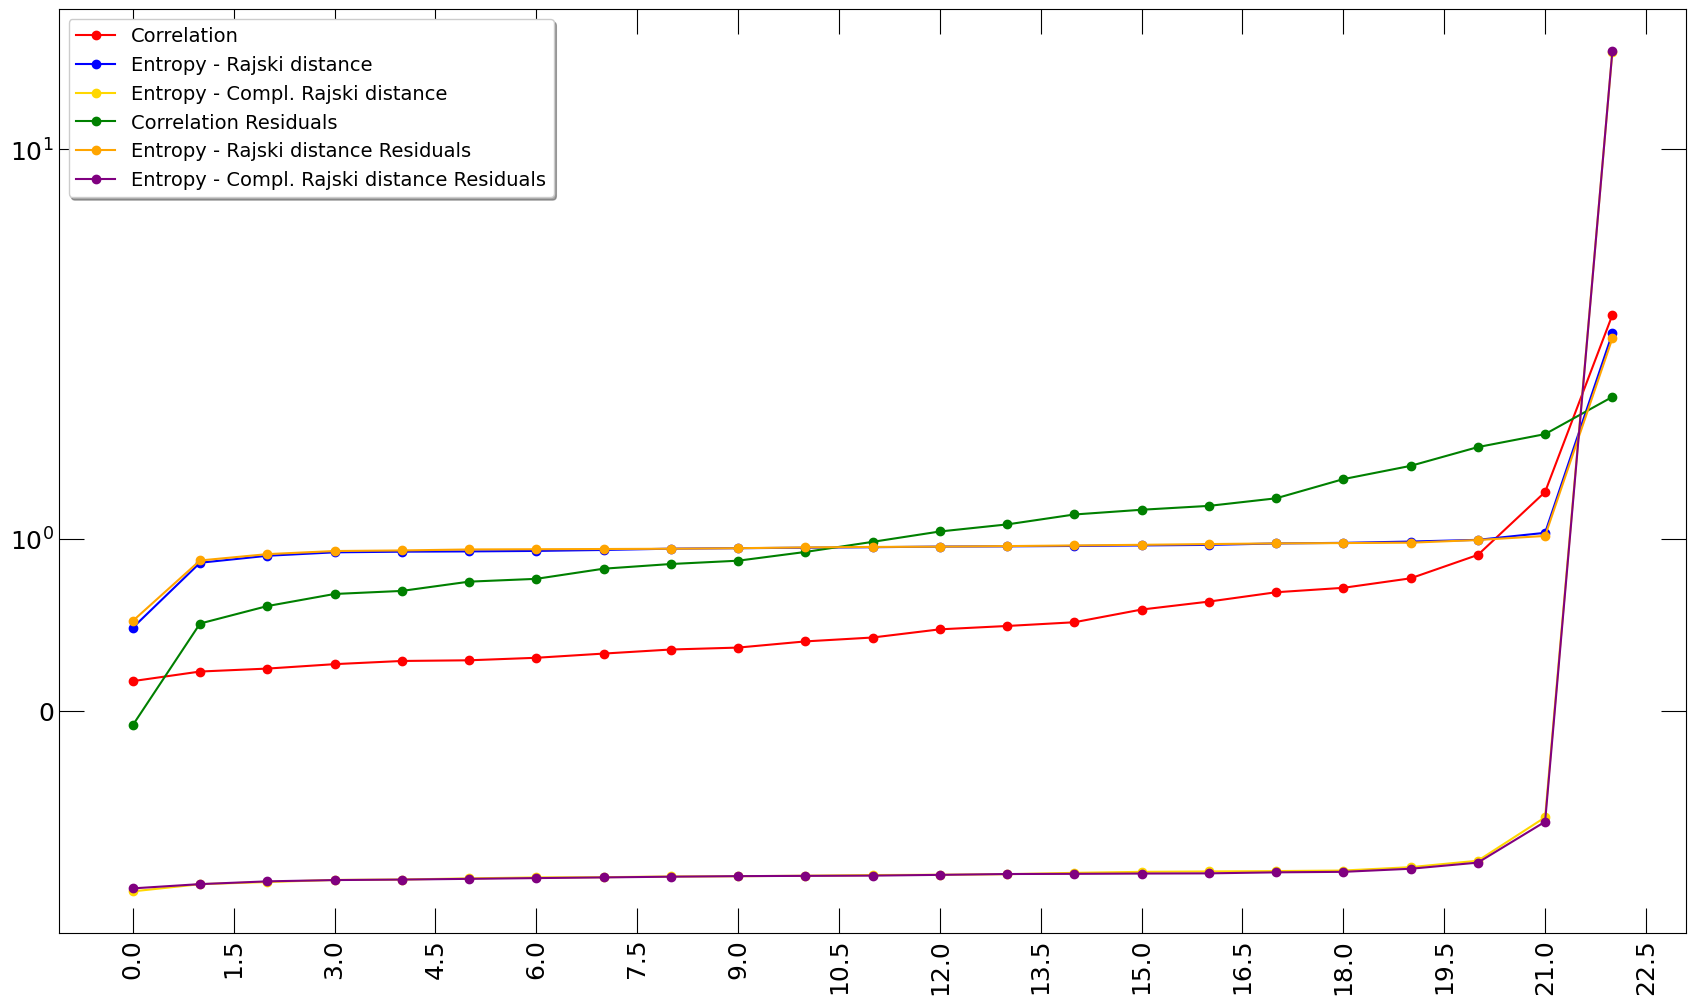

In [12]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

fig,ax = plt.subplots()
fig.set_size_inches(w = 21, h = 12)

df_8 = df_7#.tail(5)

ax.plot(df_8["eigenvalues_correlation"], color = "red", marker = "o", label = "Correlation")
ax.plot(df_8["eigenvalues_entropy"], color = "blue", marker = "o", label = "Entropy - Rajski distance")
ax.plot(df_8["eigenvalues_entropy_modified"], color = "gold", marker = "o", label = "Entropy - Compl. Rajski distance")
ax.plot(df_8["eigenvalues_correlation_res"], color = "green", marker = "o", label = "Correlation Residuals")
ax.plot(df_8["eigenvalues_entropy_res"], color = "orange", marker = "o", label = "Entropy - Rajski distance Residuals")
ax.plot(df_8["eigenvalues_entropy_modified_res"], color = "purple", marker = "o", label = "Entropy - Compl. Rajski distance Residuals")

ax.tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 18, length = 18)
ax.tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 18, length = 10)
ax.xaxis.set_major_locator(mtick.MaxNLocator(df_5.shape[0]))
ax.yaxis.set_major_locator(mtick.MaxNLocator(40))
ax.tick_params(axis = "x", labelrotation = 90)
ax.legend(fancybox = True, shadow = True, ncol = 1, fontsize = 14)

#ax.set_xscale(value = "log")
ax.set_yscale(value = "symlog")

plt.show()


## Save data

In [13]:
#df_final.to_csv("{}/df_entropy_correlation_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)

df_final.to_csv("{}/df_entropy_correlation_mxx_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)

## Exploratory Data Analysis

symbol       date  CUERVO.MX    GCC.MX  temp_1    temp_2  mask
0      2005-01-04        NaN  0.000000     NaN  0.000000     1
1      2005-01-06        NaN -0.401675     NaN -0.401675     1
2      2005-01-07        NaN  0.184588     NaN  0.184588     1
3      2005-01-10        NaN -0.525216     NaN -0.525216     1
4      2005-01-11        NaN -0.744148     NaN -0.744148     1


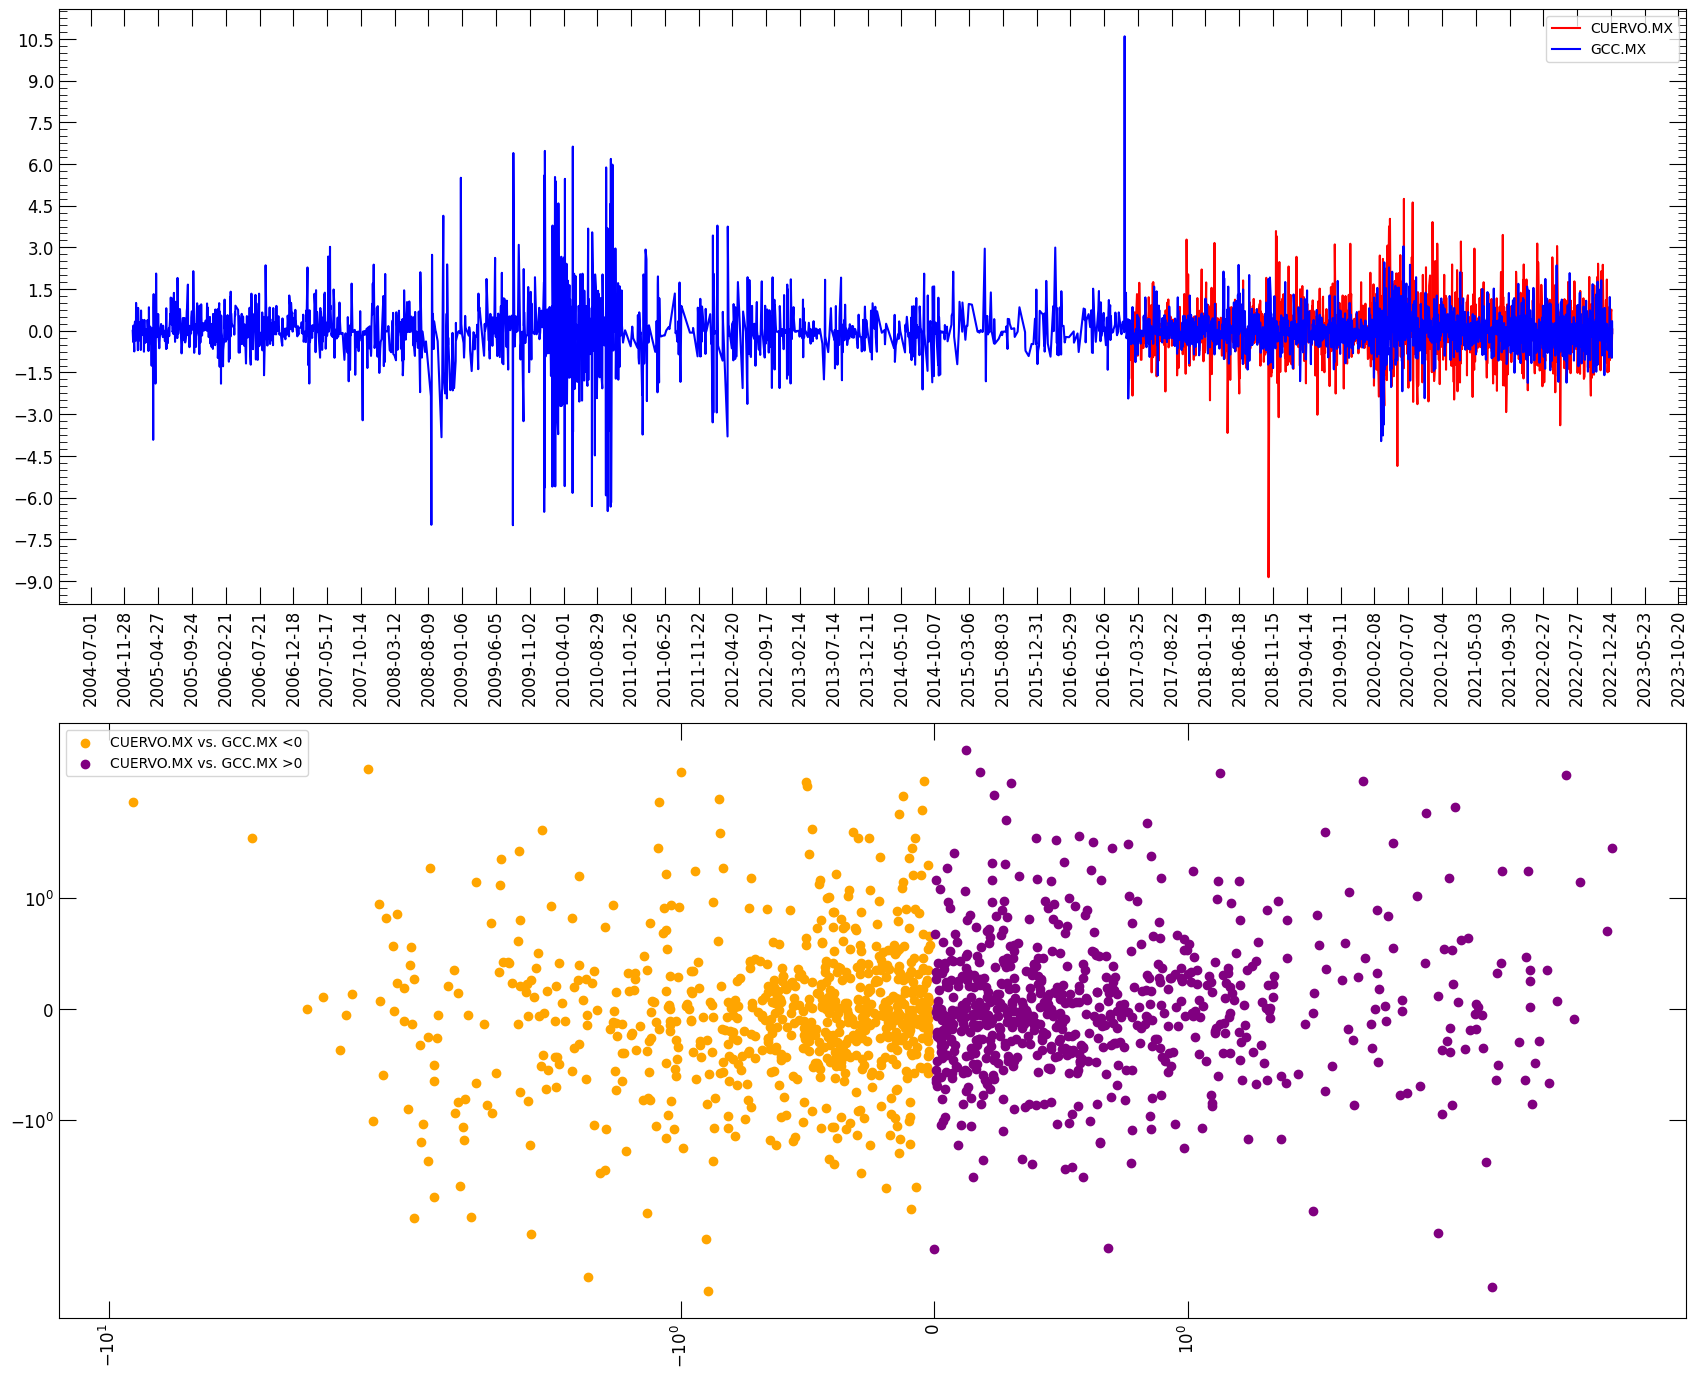

In [14]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
        .pivot(index = "date", columns = "symbol", values = column_)
        .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[shares_pair[0]] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color = "red", label = shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color = "blue", label = shares_pair[1])
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(shares_pair[0], shares_pair[1]))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(shares_pair[0], shares_pair[1]))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()


symbol       date  CUERVO.MX    GCC.MX  temp_1    temp_2  mask
0      2005-01-04        NaN  0.000000     NaN  0.000000     1
1      2005-01-06        NaN -0.401675     NaN -0.401675     1
2      2005-01-07        NaN  0.184588     NaN  0.184588     1
3      2005-01-10        NaN -0.525216     NaN -0.525216     1
4      2005-01-11        NaN -0.744148     NaN -0.744148     1


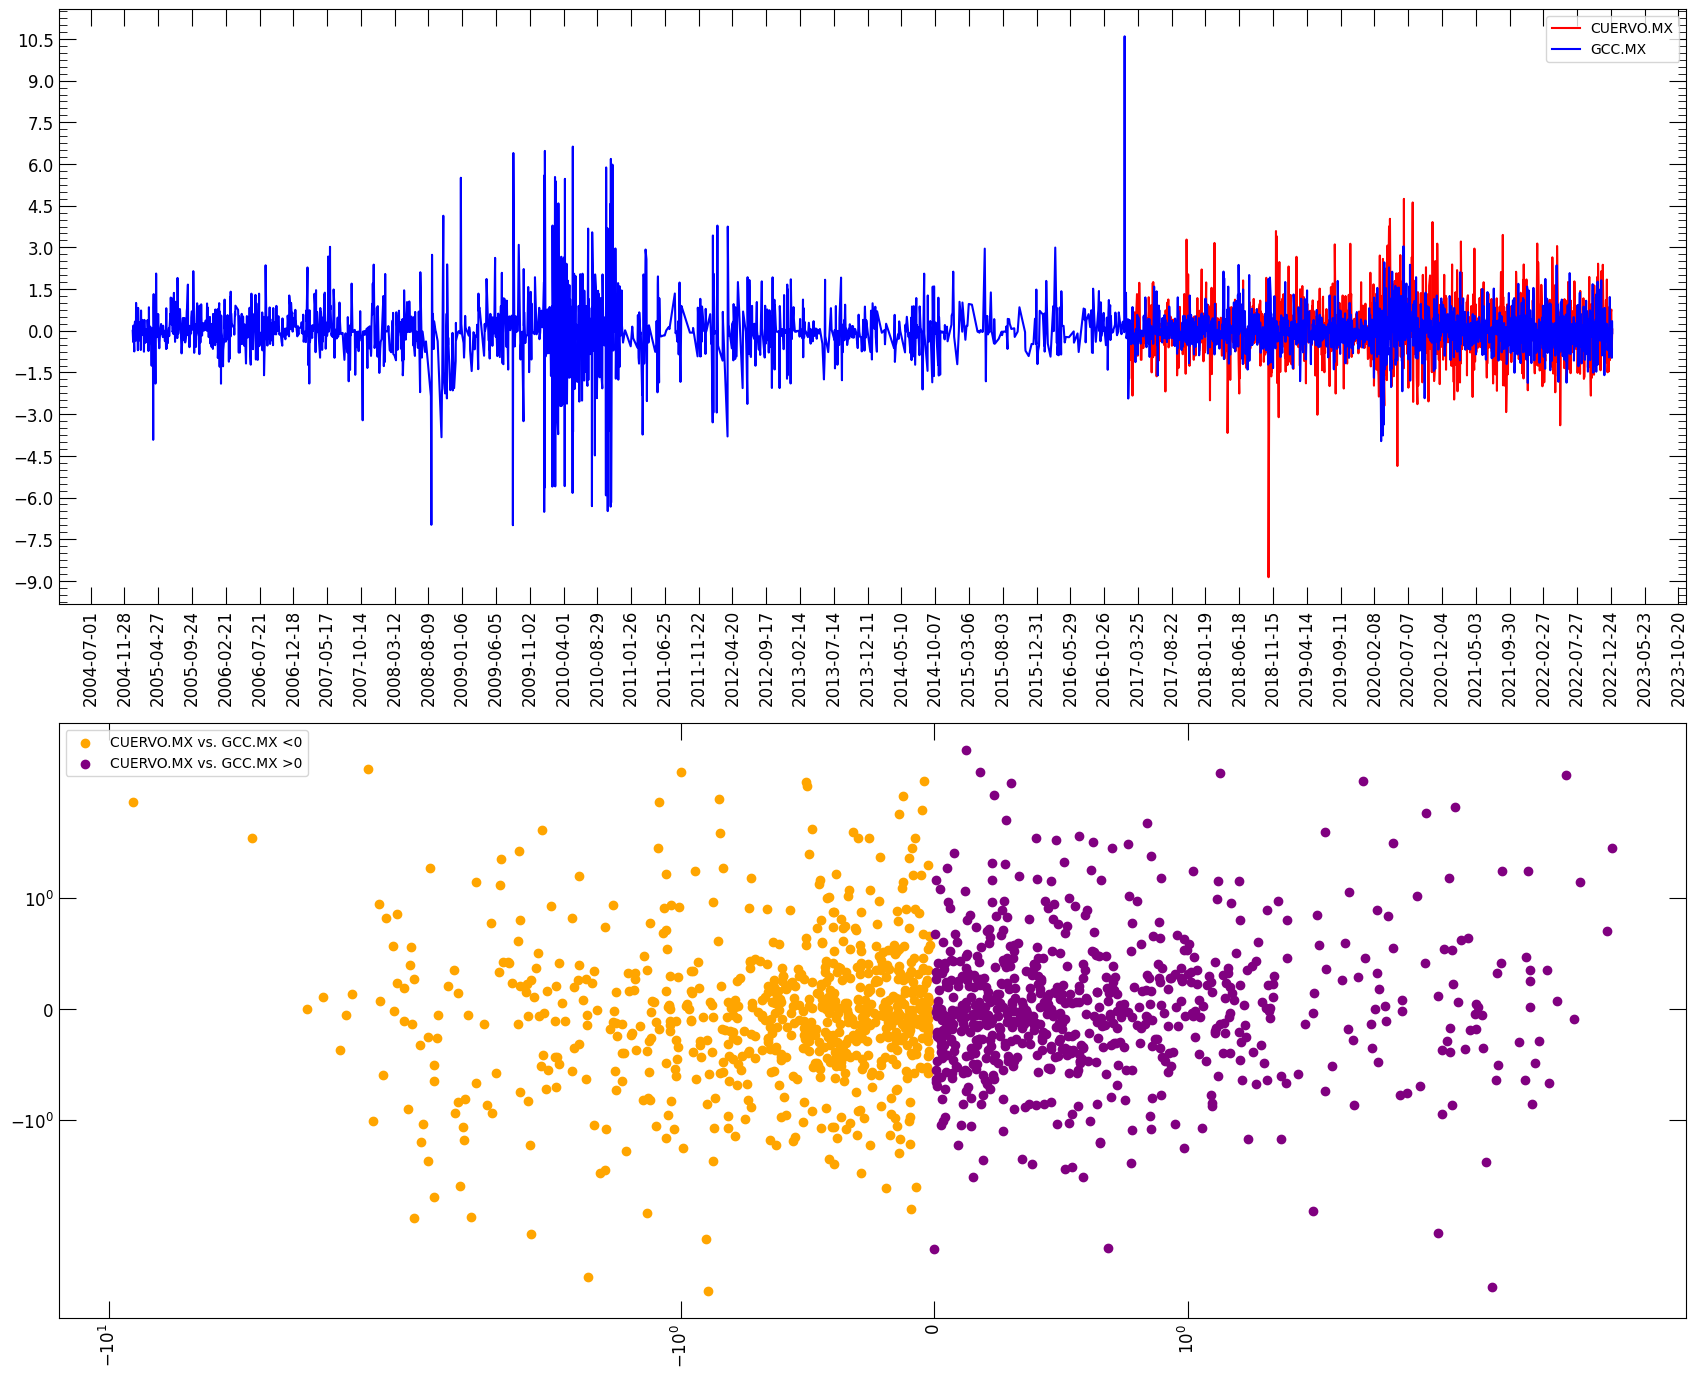

In [15]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
        .pivot(index = "date", columns = "symbol", values = column_)
        .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[shares_pair[0]] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color = "red", label = shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color = "blue", label = shares_pair[1])
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(shares_pair[0], shares_pair[1]))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(shares_pair[0], shares_pair[1]))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()


## Proofs

In [16]:
#p_i = N df.shape[1] #Shares
#q = 1/2
#m = 225
#step = 8
#n_i = int((1/q)*p_i)
#delta = 20
#k1_k0 = 8

#for i in range(m):
#    print(i)
#    start = i*delta
#    end = i*delta + n_i # slicing in dates between start and end through "independent" Windows of size n_i
#    returns = data filtered into start and end date

df = df_stock_index
time_delta = 240
time_step = 20

market_args_list = df[["date"]].sort_values(by = ["date"]).value_counts(sort = False).reset_index()
market_args_list["final_date"] = market_args_list["date"] + pd.DateOffset(days = time_delta)
market_args_list = (
    market_args_list
        .rename(columns = {"date" : "initial_date"})
        .iloc[::time_step]
        .reset_index()
        .drop(columns = ["count", "index"])
)
market_args_list["initial_date"] = market_args_list["initial_date"].astype(str)
market_args_list["final_date"] = market_args_list["final_date"].astype(str)
market_args_list#.values.tolist()


,initial_date,final_date
0,2005-01-04,2005-09-01
1,2005-02-01,2005-09-29
2,2005-03-01,2005-10-27
3,2005-03-30,2005-11-25
4,2005-04-27,2005-12-23
...,...,...
222,2022-08-25,2023-04-22
223,2022-09-23,2023-05-21
224,2022-10-21,2023-06-18
225,2022-11-22,2023-07-20


In [17]:
df_final_3 = []
for k in range(market_args_list.shape[0]):
    initial_date = market_args_list["initial_date"].values[k]
    final_date = market_args_list["final_date"].values[k]
    try:
        df_aux = emf.get_market_efficiency(
            df = df_stock_index,
            column_ = "z_score_log_return",
            min_bins = 10,
            precision = 12,
            log_path = log_path,
            log_filename = "log_market_efficiency_mxx",
            log_filename_entropy = "log_entropy_final_mxx",
            verbose = 1,
            tqdm_bar = True,
            market_args_list = (initial_date, final_date),
            bouchaud_filter = False,
            n = int(df_stock_index.shape[0] * 2),
            df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
            alphas = [0.01, 0.05, 0.10],
            k_max = 8,
            df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
            levels = [1, 2, 5, 10]
        )

        df_final_3.append(df_aux)

        print("Finished: {} - {}".format(initial_date, final_date))
    except:
        print("No done: {} - {}".format(initial_date, final_date))

df_final_3 = pd.concat(df_final_3)

100%|███████████████████████| 45/45 [00:02<00:00, 15.14it/s]


No done: 2005-01-04 - 2005-09-01


100%|███████████████████████| 45/45 [00:02<00:00, 15.76it/s]


No done: 2005-02-01 - 2005-09-29


100%|███████████████████████| 45/45 [00:02<00:00, 15.62it/s]


No done: 2005-03-01 - 2005-10-27


100%|███████████████████████| 45/45 [00:02<00:00, 15.33it/s]


No done: 2005-03-30 - 2005-11-25


100%|███████████████████████| 45/45 [00:02<00:00, 17.16it/s]


No done: 2005-04-27 - 2005-12-23


100%|███████████████████████| 45/45 [00:02<00:00, 15.61it/s]


No done: 2005-05-25 - 2006-01-20


100%|███████████████████████| 45/45 [00:02<00:00, 17.11it/s]


No done: 2005-06-22 - 2006-02-17


100%|███████████████████████| 45/45 [00:02<00:00, 17.04it/s]


No done: 2005-07-20 - 2006-03-17


100%|███████████████████████| 45/45 [00:02<00:00, 18.08it/s]


No done: 2005-08-17 - 2006-04-14


100%|███████████████████████| 45/45 [00:02<00:00, 16.82it/s]


No done: 2005-09-14 - 2006-05-12


100%|███████████████████████| 55/55 [00:02<00:00, 21.21it/s]


Finished: 2005-10-12 - 2006-06-09


100%|███████████████████████| 55/55 [00:02<00:00, 19.95it/s]


Finished: 2005-11-09 - 2006-07-07


100%|███████████████████████| 66/66 [00:02<00:00, 23.32it/s]


Finished: 2005-12-07 - 2006-08-04


100%|███████████████████████| 66/66 [00:02<00:00, 25.07it/s]


Finished: 2006-01-04 - 2006-09-01


100%|███████████████████████| 66/66 [00:02<00:00, 25.22it/s]


Finished: 2006-02-01 - 2006-09-29


100%|███████████████████████| 66/66 [00:02<00:00, 25.13it/s]


Finished: 2006-03-01 - 2006-10-27


100%|███████████████████████| 66/66 [00:02<00:00, 24.01it/s]


Finished: 2006-03-29 - 2006-11-24


100%|███████████████████████| 66/66 [00:02<00:00, 22.12it/s]


Finished: 2006-04-27 - 2006-12-23


100%|███████████████████████| 66/66 [00:03<00:00, 21.59it/s]


Finished: 2006-05-26 - 2007-01-21


100%|███████████████████████| 66/66 [00:02<00:00, 24.27it/s]


Finished: 2006-06-23 - 2007-02-18


100%|███████████████████████| 66/66 [00:02<00:00, 24.79it/s]


Finished: 2006-07-21 - 2007-03-18


100%|███████████████████████| 66/66 [00:02<00:00, 23.73it/s]


Finished: 2006-08-18 - 2007-04-15


100%|███████████████████████| 78/78 [00:02<00:00, 28.67it/s]


Finished: 2006-09-15 - 2007-05-13


100%|███████████████████████| 78/78 [00:03<00:00, 24.80it/s]


Finished: 2006-10-13 - 2007-06-10


100%|███████████████████████| 78/78 [00:02<00:00, 28.83it/s]


Finished: 2006-11-10 - 2007-07-08


100%|███████████████████████| 78/78 [00:02<00:00, 26.22it/s]


Finished: 2006-12-08 - 2007-08-05


100%|███████████████████████| 78/78 [00:02<00:00, 27.94it/s]


Finished: 2007-01-08 - 2007-09-05


100%|███████████████████████| 78/78 [00:02<00:00, 28.14it/s]


Finished: 2007-02-05 - 2007-10-03


100%|███████████████████████| 78/78 [00:02<00:00, 28.30it/s]


Finished: 2007-03-06 - 2007-11-01


100%|███████████████████████| 78/78 [00:02<00:00, 27.66it/s]


Finished: 2007-04-03 - 2007-11-29


100%|███████████████████████| 78/78 [00:02<00:00, 27.12it/s]


Finished: 2007-05-04 - 2007-12-30


100%|███████████████████████| 78/78 [00:02<00:00, 27.56it/s]


Finished: 2007-06-01 - 2008-01-27


100%|███████████████████████| 66/66 [00:02<00:00, 23.74it/s]


Finished: 2007-06-29 - 2008-02-24


100%|███████████████████████| 66/66 [00:02<00:00, 23.43it/s]


Finished: 2007-07-27 - 2008-03-23


100%|███████████████████████| 91/91 [00:03<00:00, 29.01it/s]


Finished: 2007-08-24 - 2008-04-20


100%|███████████████████████| 91/91 [00:02<00:00, 32.27it/s]


Finished: 2007-09-21 - 2008-05-18


100%|█████████████████████| 153/153 [00:03<00:00, 50.01it/s]


Finished: 2007-10-19 - 2008-06-15


100%|█████████████████████| 136/136 [00:02<00:00, 45.46it/s]


Finished: 2007-11-19 - 2008-07-16


100%|█████████████████████| 136/136 [00:03<00:00, 44.05it/s]


Finished: 2007-12-18 - 2008-08-14


100%|█████████████████████| 136/136 [00:03<00:00, 43.92it/s]


Finished: 2008-01-17 - 2008-09-13


100%|█████████████████████| 136/136 [00:03<00:00, 45.19it/s]


Finished: 2008-02-15 - 2008-10-12


100%|█████████████████████| 153/153 [00:03<00:00, 48.96it/s]


Finished: 2008-03-14 - 2008-11-09


100%|█████████████████████| 171/171 [00:03<00:00, 55.28it/s]


Finished: 2008-04-16 - 2008-12-12


100%|█████████████████████| 171/171 [00:03<00:00, 45.65it/s]


Finished: 2008-05-15 - 2009-01-10


100%|█████████████████████| 171/171 [00:03<00:00, 50.89it/s]


Finished: 2008-06-12 - 2009-02-07


100%|█████████████████████| 171/171 [00:03<00:00, 51.52it/s]


Finished: 2008-07-10 - 2009-03-07


100%|█████████████████████| 171/171 [00:03<00:00, 54.33it/s]


Finished: 2008-08-07 - 2009-04-04


100%|█████████████████████| 171/171 [00:03<00:00, 53.01it/s]


Finished: 2008-09-04 - 2009-05-02


100%|█████████████████████| 171/171 [00:03<00:00, 54.31it/s]


Finished: 2008-10-03 - 2009-05-31


100%|█████████████████████| 171/171 [00:03<00:00, 53.77it/s]


Finished: 2008-10-31 - 2009-06-28


100%|█████████████████████| 171/171 [00:03<00:00, 54.49it/s]


Finished: 2008-12-01 - 2009-07-29


100%|█████████████████████| 171/171 [00:03<00:00, 54.76it/s]


Finished: 2008-12-31 - 2009-08-28


100%|█████████████████████| 171/171 [00:03<00:00, 52.44it/s]


Finished: 2009-01-29 - 2009-09-26


100%|█████████████████████| 171/171 [00:03<00:00, 54.84it/s]


Finished: 2009-02-26 - 2009-10-24


100%|█████████████████████| 171/171 [00:03<00:00, 55.78it/s]


Finished: 2009-03-27 - 2009-11-22


100%|█████████████████████| 171/171 [00:03<00:00, 55.29it/s]


Finished: 2009-04-28 - 2009-12-24


100%|█████████████████████| 171/171 [00:03<00:00, 54.61it/s]


Finished: 2009-05-27 - 2010-01-22


100%|█████████████████████| 171/171 [00:03<00:00, 56.99it/s]


Finished: 2009-06-24 - 2010-02-19


100%|█████████████████████| 171/171 [00:02<00:00, 57.22it/s]


Finished: 2009-07-22 - 2010-03-19


100%|█████████████████████| 171/171 [00:03<00:00, 56.19it/s]


Finished: 2009-08-19 - 2010-04-16


100%|█████████████████████| 171/171 [00:03<00:00, 54.28it/s]


Finished: 2009-09-17 - 2010-05-15


100%|█████████████████████| 190/190 [00:03<00:00, 58.22it/s]


Finished: 2009-10-15 - 2010-06-12


100%|█████████████████████| 190/190 [00:03<00:00, 58.37it/s]


Finished: 2009-11-13 - 2010-07-11


100%|█████████████████████| 190/190 [00:03<00:00, 54.69it/s]


Finished: 2009-12-14 - 2010-08-11


100%|█████████████████████| 190/190 [00:03<00:00, 48.67it/s]


Finished: 2010-01-13 - 2010-09-10


100%|█████████████████████| 190/190 [00:03<00:00, 47.66it/s]


Finished: 2010-02-11 - 2010-10-09


100%|█████████████████████| 190/190 [00:03<00:00, 53.18it/s]


Finished: 2010-03-11 - 2010-11-06


100%|█████████████████████| 190/190 [00:03<00:00, 50.91it/s]


Finished: 2010-04-13 - 2010-12-09


100%|█████████████████████| 190/190 [00:03<00:00, 52.98it/s]


Finished: 2010-05-12 - 2011-01-07


100%|█████████████████████| 190/190 [00:03<00:00, 53.65it/s]


Finished: 2010-06-09 - 2011-02-04


100%|█████████████████████| 190/190 [00:03<00:00, 50.94it/s]


Finished: 2010-07-07 - 2011-03-04


100%|█████████████████████| 190/190 [00:03<00:00, 54.84it/s]


Finished: 2010-08-04 - 2011-04-01


100%|█████████████████████| 171/171 [00:03<00:00, 45.98it/s]


Finished: 2010-09-01 - 2011-04-29


100%|█████████████████████| 171/171 [00:03<00:00, 49.61it/s]


Finished: 2010-10-01 - 2011-05-29


100%|█████████████████████| 190/190 [00:03<00:00, 51.13it/s]


Finished: 2010-10-29 - 2011-06-26


100%|█████████████████████| 190/190 [00:04<00:00, 47.44it/s]


Finished: 2010-11-30 - 2011-07-28


100%|█████████████████████| 190/190 [00:03<00:00, 49.63it/s]


Finished: 2010-12-29 - 2011-08-26


100%|█████████████████████| 190/190 [00:03<00:00, 55.98it/s]


Finished: 2011-01-27 - 2011-09-24


100%|█████████████████████| 190/190 [00:03<00:00, 53.30it/s]


Finished: 2011-02-25 - 2011-10-23


100%|█████████████████████| 190/190 [00:03<00:00, 53.57it/s]


Finished: 2011-03-28 - 2011-11-23


100%|█████████████████████| 190/190 [00:03<00:00, 54.06it/s]


Finished: 2011-05-02 - 2011-12-28


100%|█████████████████████| 190/190 [00:03<00:00, 55.97it/s]


Finished: 2011-05-30 - 2012-01-25


100%|█████████████████████| 190/190 [00:03<00:00, 55.05it/s]


Finished: 2011-06-27 - 2012-02-22


100%|█████████████████████| 190/190 [00:03<00:00, 55.07it/s]


Finished: 2011-07-25 - 2012-03-21


100%|█████████████████████| 190/190 [00:03<00:00, 56.25it/s]


Finished: 2011-08-22 - 2012-04-18


100%|█████████████████████| 190/190 [00:03<00:00, 56.19it/s]


Finished: 2011-09-20 - 2012-05-17


100%|█████████████████████| 190/190 [00:03<00:00, 57.29it/s]


Finished: 2011-10-18 - 2012-06-14


100%|█████████████████████| 190/190 [00:03<00:00, 56.20it/s]


Finished: 2011-11-16 - 2012-07-13


100%|█████████████████████| 190/190 [00:03<00:00, 48.83it/s]


Finished: 2011-12-16 - 2012-08-12


100%|█████████████████████| 190/190 [00:03<00:00, 52.90it/s]


Finished: 2012-01-16 - 2012-09-12


100%|█████████████████████| 210/210 [00:03<00:00, 57.22it/s]


Finished: 2012-02-14 - 2012-10-11


100%|█████████████████████| 210/210 [00:03<00:00, 60.60it/s]


Finished: 2012-03-13 - 2012-11-08


100%|█████████████████████| 210/210 [00:03<00:00, 58.74it/s]


Finished: 2012-04-13 - 2012-12-09


100%|█████████████████████| 210/210 [00:03<00:00, 57.06it/s]


Finished: 2012-05-14 - 2013-01-09


100%|█████████████████████| 231/231 [00:03<00:00, 60.96it/s]


Finished: 2012-06-11 - 2013-02-06


100%|█████████████████████| 231/231 [00:03<00:00, 60.07it/s]


Finished: 2012-07-10 - 2013-03-07


100%|█████████████████████| 210/210 [00:03<00:00, 55.27it/s]


Finished: 2012-08-07 - 2013-04-04


100%|█████████████████████| 231/231 [00:03<00:00, 64.91it/s]


Finished: 2012-09-04 - 2013-05-02


100%|█████████████████████| 210/210 [00:03<00:00, 55.04it/s]


Finished: 2012-10-03 - 2013-05-31


100%|█████████████████████| 210/210 [00:04<00:00, 51.49it/s]


Finished: 2012-10-31 - 2013-06-28


100%|█████████████████████| 210/210 [00:04<00:00, 50.20it/s]


Finished: 2012-12-03 - 2013-07-31


100%|█████████████████████| 210/210 [00:03<00:00, 54.32it/s]


Finished: 2013-01-03 - 2013-08-31


100%|█████████████████████| 210/210 [00:03<00:00, 59.56it/s]


Finished: 2013-01-31 - 2013-09-28


100%|█████████████████████| 210/210 [00:03<00:00, 53.67it/s]


Finished: 2013-03-01 - 2013-10-27


100%|█████████████████████| 210/210 [00:03<00:00, 54.79it/s]


Finished: 2013-04-03 - 2013-11-29


100%|█████████████████████| 210/210 [00:03<00:00, 53.49it/s]


Finished: 2013-05-02 - 2013-12-28


100%|█████████████████████| 210/210 [00:03<00:00, 54.94it/s]


Finished: 2013-05-30 - 2014-01-25


100%|█████████████████████| 210/210 [00:03<00:00, 53.25it/s]


Finished: 2013-06-27 - 2014-02-22


100%|█████████████████████| 210/210 [00:03<00:00, 55.49it/s]


Finished: 2013-07-25 - 2014-03-22


100%|█████████████████████| 210/210 [00:04<00:00, 51.63it/s]


Finished: 2013-08-22 - 2014-04-19


100%|█████████████████████| 210/210 [00:03<00:00, 55.38it/s]


Finished: 2013-09-20 - 2014-05-18


100%|█████████████████████| 210/210 [00:03<00:00, 53.25it/s]


Finished: 2013-10-18 - 2014-06-15


100%|█████████████████████| 210/210 [00:03<00:00, 54.34it/s]


Finished: 2013-11-15 - 2014-07-13


100%|█████████████████████| 210/210 [00:03<00:00, 54.85it/s]


Finished: 2013-12-17 - 2014-08-14


100%|█████████████████████| 210/210 [00:03<00:00, 54.52it/s]


Finished: 2014-01-20 - 2014-09-17


100%|█████████████████████| 210/210 [00:03<00:00, 57.17it/s]


Finished: 2014-02-18 - 2014-10-16


100%|█████████████████████| 210/210 [00:04<00:00, 51.60it/s]


Finished: 2014-03-19 - 2014-11-14


100%|█████████████████████| 210/210 [00:04<00:00, 48.21it/s]


Finished: 2014-04-16 - 2014-12-12


100%|█████████████████████| 210/210 [00:03<00:00, 53.27it/s]


Finished: 2014-05-19 - 2015-01-14


100%|█████████████████████| 210/210 [00:04<00:00, 50.49it/s]


Finished: 2014-06-16 - 2015-02-11


100%|█████████████████████| 210/210 [00:03<00:00, 57.47it/s]


Finished: 2014-07-14 - 2015-03-11


100%|█████████████████████| 210/210 [00:04<00:00, 49.26it/s]


Finished: 2014-08-11 - 2015-04-08


100%|█████████████████████| 210/210 [00:03<00:00, 57.01it/s]


Finished: 2014-09-08 - 2015-05-06


100%|█████████████████████| 210/210 [00:04<00:00, 52.19it/s]


Finished: 2014-10-07 - 2015-06-04


100%|█████████████████████| 210/210 [00:03<00:00, 52.70it/s]


Finished: 2014-11-04 - 2015-07-02


100%|█████████████████████| 210/210 [00:03<00:00, 58.21it/s]


Finished: 2014-12-03 - 2015-07-31


100%|█████████████████████| 210/210 [00:03<00:00, 55.77it/s]


Finished: 2015-01-05 - 2015-09-02


100%|█████████████████████| 210/210 [00:03<00:00, 54.83it/s]


Finished: 2015-02-03 - 2015-10-01


100%|█████████████████████| 210/210 [00:03<00:00, 53.80it/s]


Finished: 2015-03-03 - 2015-10-29


100%|█████████████████████| 210/210 [00:04<00:00, 51.12it/s]


Finished: 2015-04-01 - 2015-11-27


100%|█████████████████████| 210/210 [00:04<00:00, 48.20it/s]


Finished: 2015-05-04 - 2015-12-30


100%|█████████████████████| 210/210 [00:04<00:00, 48.52it/s]


Finished: 2015-06-01 - 2016-01-27


100%|█████████████████████| 210/210 [00:04<00:00, 46.78it/s]


Finished: 2015-06-29 - 2016-02-24


100%|█████████████████████| 210/210 [00:04<00:00, 44.33it/s]


Finished: 2015-07-27 - 2016-03-23


100%|█████████████████████| 210/210 [00:04<00:00, 47.23it/s]


Finished: 2015-08-24 - 2016-04-20


100%|█████████████████████| 210/210 [00:04<00:00, 43.29it/s]


Finished: 2015-09-22 - 2016-05-19


100%|█████████████████████| 210/210 [00:05<00:00, 39.68it/s]


Finished: 2015-10-20 - 2016-06-16


100%|█████████████████████| 210/210 [00:05<00:00, 41.03it/s]


Finished: 2015-11-19 - 2016-07-16


100%|█████████████████████| 210/210 [00:04<00:00, 44.59it/s]


Finished: 2015-12-17 - 2016-08-13


100%|█████████████████████| 210/210 [00:06<00:00, 34.81it/s]


Finished: 2016-01-18 - 2016-09-14


100%|█████████████████████| 210/210 [00:05<00:00, 40.56it/s]


Finished: 2016-02-16 - 2016-10-13


100%|█████████████████████| 210/210 [00:04<00:00, 48.28it/s]


Finished: 2016-03-15 - 2016-11-10


100%|█████████████████████| 210/210 [00:04<00:00, 43.07it/s]


Finished: 2016-04-15 - 2016-12-11


100%|█████████████████████| 210/210 [00:04<00:00, 43.52it/s]


Finished: 2016-05-13 - 2017-01-08


100%|█████████████████████| 210/210 [00:04<00:00, 50.75it/s]


Finished: 2016-06-10 - 2017-02-05


100%|█████████████████████| 210/210 [00:04<00:00, 47.88it/s]


Finished: 2016-07-08 - 2017-03-05


100%|█████████████████████| 210/210 [00:04<00:00, 49.88it/s]


Finished: 2016-08-05 - 2017-04-02


100%|█████████████████████| 231/231 [00:04<00:00, 52.63it/s]


Finished: 2016-09-02 - 2017-04-30


100%|█████████████████████| 231/231 [00:03<00:00, 59.34it/s]


Finished: 2016-10-03 - 2017-05-31


100%|█████████████████████| 231/231 [00:03<00:00, 66.33it/s]


Finished: 2016-10-31 - 2017-06-28


100%|█████████████████████| 253/253 [00:03<00:00, 74.09it/s]


Finished: 2016-11-30 - 2017-07-28


100%|█████████████████████| 253/253 [00:04<00:00, 61.76it/s]


Finished: 2016-12-29 - 2017-08-26


100%|█████████████████████| 253/253 [00:04<00:00, 57.95it/s]


Finished: 2017-01-27 - 2017-09-24


100%|█████████████████████| 253/253 [00:03<00:00, 65.54it/s]


Finished: 2017-02-27 - 2017-10-25


100%|█████████████████████| 276/276 [00:03<00:00, 73.66it/s]


Finished: 2017-03-28 - 2017-11-23


100%|█████████████████████| 276/276 [00:03<00:00, 75.33it/s]


Finished: 2017-04-27 - 2017-12-23


100%|█████████████████████| 276/276 [00:03<00:00, 74.70it/s]


Finished: 2017-05-26 - 2018-01-21


100%|█████████████████████| 276/276 [00:03<00:00, 75.23it/s]


Finished: 2017-06-23 - 2018-02-18


100%|█████████████████████| 276/276 [00:03<00:00, 74.30it/s]


Finished: 2017-07-21 - 2018-03-18


100%|█████████████████████| 276/276 [00:03<00:00, 77.41it/s]


Finished: 2017-08-18 - 2018-04-15


100%|█████████████████████| 276/276 [00:03<00:00, 75.25it/s]


Finished: 2017-09-15 - 2018-05-13


100%|█████████████████████| 276/276 [00:03<00:00, 77.47it/s]


Finished: 2017-10-13 - 2018-06-10


100%|█████████████████████| 276/276 [00:03<00:00, 77.23it/s]


Finished: 2017-11-13 - 2018-07-11


100%|█████████████████████| 276/276 [00:03<00:00, 74.10it/s]


Finished: 2017-12-13 - 2018-08-10


100%|█████████████████████| 276/276 [00:03<00:00, 76.19it/s]


Finished: 2018-01-12 - 2018-09-09


100%|█████████████████████| 276/276 [00:03<00:00, 77.64it/s]


Finished: 2018-02-12 - 2018-10-10


100%|█████████████████████| 276/276 [00:03<00:00, 73.96it/s]


Finished: 2018-03-12 - 2018-11-07


100%|█████████████████████| 276/276 [00:03<00:00, 76.73it/s]


Finished: 2018-04-12 - 2018-12-08


100%|█████████████████████| 276/276 [00:03<00:00, 77.10it/s]


Finished: 2018-05-11 - 2019-01-06


100%|█████████████████████| 276/276 [00:03<00:00, 76.44it/s]


Finished: 2018-06-08 - 2019-02-03


100%|█████████████████████| 276/276 [00:03<00:00, 74.13it/s]


Finished: 2018-07-06 - 2019-03-03


100%|█████████████████████| 276/276 [00:03<00:00, 73.37it/s]


Finished: 2018-08-03 - 2019-03-31


100%|█████████████████████| 276/276 [00:03<00:00, 76.18it/s]


Finished: 2018-08-31 - 2019-04-28


100%|█████████████████████| 276/276 [00:03<00:00, 76.85it/s]


Finished: 2018-09-28 - 2019-05-26


100%|█████████████████████| 276/276 [00:03<00:00, 76.62it/s]


Finished: 2018-10-26 - 2019-06-23


100%|█████████████████████| 276/276 [00:03<00:00, 75.63it/s]


Finished: 2018-11-27 - 2019-07-25


100%|█████████████████████| 276/276 [00:03<00:00, 75.48it/s]


Finished: 2018-12-27 - 2019-08-24


100%|█████████████████████| 276/276 [00:03<00:00, 77.40it/s]


Finished: 2019-01-25 - 2019-09-22


100%|█████████████████████| 276/276 [00:03<00:00, 77.32it/s]


Finished: 2019-02-25 - 2019-10-23


100%|█████████████████████| 276/276 [00:03<00:00, 75.59it/s]


Finished: 2019-03-26 - 2019-11-21


100%|█████████████████████| 276/276 [00:03<00:00, 76.42it/s]


Finished: 2019-04-25 - 2019-12-21


100%|█████████████████████| 276/276 [00:03<00:00, 75.95it/s]


Finished: 2019-05-24 - 2020-01-19


100%|█████████████████████| 276/276 [00:03<00:00, 76.74it/s]


Finished: 2019-06-21 - 2020-02-16


100%|█████████████████████| 276/276 [00:03<00:00, 77.72it/s]


Finished: 2019-07-19 - 2020-03-15


100%|█████████████████████| 276/276 [00:03<00:00, 72.78it/s]


Finished: 2019-08-16 - 2020-04-12


100%|█████████████████████| 276/276 [00:03<00:00, 75.27it/s]


Finished: 2019-09-13 - 2020-05-10


100%|█████████████████████| 276/276 [00:03<00:00, 74.51it/s]


Finished: 2019-10-14 - 2020-06-10


100%|█████████████████████| 276/276 [00:03<00:00, 78.04it/s]


Finished: 2019-11-11 - 2020-07-08


100%|█████████████████████| 276/276 [00:03<00:00, 76.71it/s]


Finished: 2019-12-10 - 2020-08-06


100%|█████████████████████| 276/276 [00:03<00:00, 76.86it/s]


Finished: 2020-01-13 - 2020-09-09


100%|█████████████████████| 276/276 [00:03<00:00, 75.62it/s]


Finished: 2020-02-11 - 2020-10-08


100%|█████████████████████| 276/276 [00:03<00:00, 75.07it/s]


Finished: 2020-03-10 - 2020-11-05


100%|█████████████████████| 276/276 [00:03<00:00, 77.03it/s]


Finished: 2020-04-08 - 2020-12-04


100%|█████████████████████| 276/276 [00:03<00:00, 76.43it/s]


Finished: 2020-05-11 - 2021-01-06


100%|█████████████████████| 276/276 [00:03<00:00, 75.72it/s]


Finished: 2020-06-08 - 2021-02-03


100%|█████████████████████| 276/276 [00:03<00:00, 77.75it/s]


Finished: 2020-07-06 - 2021-03-03


100%|█████████████████████| 276/276 [00:03<00:00, 76.30it/s]


Finished: 2020-08-03 - 2021-03-31


100%|█████████████████████| 276/276 [00:03<00:00, 73.80it/s]


Finished: 2020-08-31 - 2021-04-28


100%|█████████████████████| 276/276 [00:03<00:00, 75.55it/s]


Finished: 2020-09-29 - 2021-05-27


100%|█████████████████████| 276/276 [00:03<00:00, 78.04it/s]


Finished: 2020-10-29 - 2021-06-26


100%|█████████████████████| 276/276 [00:03<00:00, 75.02it/s]


Finished: 2020-11-30 - 2021-07-28


100%|█████████████████████| 276/276 [00:03<00:00, 77.62it/s]


Finished: 2020-12-29 - 2021-08-26


100%|█████████████████████| 276/276 [00:03<00:00, 77.23it/s]


Finished: 2021-01-27 - 2021-09-24


100%|█████████████████████| 276/276 [00:03<00:00, 75.78it/s]


Finished: 2021-02-25 - 2021-10-23


100%|█████████████████████| 276/276 [00:03<00:00, 77.63it/s]


Finished: 2021-03-26 - 2021-11-21


100%|█████████████████████| 276/276 [00:03<00:00, 73.71it/s]


Finished: 2021-04-27 - 2021-12-23


100%|█████████████████████| 276/276 [00:03<00:00, 74.27it/s]


Finished: 2021-05-25 - 2022-01-20


100%|█████████████████████| 276/276 [00:03<00:00, 74.39it/s]


Finished: 2021-06-22 - 2022-02-17


100%|█████████████████████| 276/276 [00:04<00:00, 55.59it/s]


Finished: 2021-07-20 - 2022-03-17


100%|█████████████████████| 276/276 [00:03<00:00, 69.03it/s]


Finished: 2021-08-17 - 2022-04-14


100%|█████████████████████| 276/276 [00:04<00:00, 63.01it/s]


Finished: 2021-09-14 - 2022-05-12


100%|█████████████████████| 276/276 [00:03<00:00, 69.88it/s]


Finished: 2021-10-13 - 2022-06-10


100%|█████████████████████| 276/276 [00:03<00:00, 74.04it/s]


Finished: 2021-11-11 - 2022-07-09


100%|█████████████████████| 276/276 [00:03<00:00, 74.60it/s]


Finished: 2021-12-10 - 2022-08-07


100%|█████████████████████| 276/276 [00:04<00:00, 64.63it/s]


Finished: 2022-01-07 - 2022-09-04


100%|█████████████████████| 276/276 [00:04<00:00, 64.94it/s]


Finished: 2022-02-04 - 2022-10-02


100%|█████████████████████| 276/276 [00:04<00:00, 66.38it/s]


Finished: 2022-03-07 - 2022-11-02


100%|█████████████████████| 276/276 [00:04<00:00, 62.38it/s]


Finished: 2022-04-05 - 2022-12-01


100%|█████████████████████| 276/276 [00:04<00:00, 59.63it/s]


Finished: 2022-05-05 - 2022-12-31


100%|█████████████████████| 276/276 [00:04<00:00, 60.82it/s]


Finished: 2022-06-02 - 2023-01-28


100%|█████████████████████| 276/276 [00:03<00:00, 75.69it/s]


Finished: 2022-06-30 - 2023-02-25


100%|█████████████████████| 276/276 [00:03<00:00, 69.71it/s]


Finished: 2022-07-28 - 2023-03-25


0it [00:00, ?it/s]


No done: 2022-08-25 - 2023-04-22


0it [00:00, ?it/s]


No done: 2022-09-23 - 2023-05-21


0it [00:00, ?it/s]


No done: 2022-10-21 - 2023-06-18


0it [00:00, ?it/s]


No done: 2022-11-22 - 2023-07-20


0it [00:00, ?it/s]

No done: 2022-12-21 - 2023-08-18


In [18]:
df_final_4 = []
for k in range(market_args_list.shape[0]):
    initial_date = market_args_list["initial_date"].values[k]
    final_date = market_args_list["final_date"].values[k]
    try:
        df_aux = emf.get_market_efficiency(
            df = df_stock_index,
            column_ = "z_score_zlr_no_market",
            min_bins = 10,
            precision = 12,
            log_path = log_path,
            log_filename = "log_market_efficiency_mxx_2",
            log_filename_entropy = "log_entropy_final_mxx_2",
            verbose = 1,
            tqdm_bar = True,
            market_args_list = (initial_date, final_date),
            bouchaud_filter = False,
            n = int(df_stock_index.shape[0] * 2),
            df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
            alphas = [0.01, 0.05, 0.10],
            k_max = 8,
            df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
            levels = [1, 2, 5, 10]
        )

        df_final_4.append(df_aux)

        print("Finished: {} - {}".format(initial_date, final_date))
    except:
        print("No done: {} - {}".format(initial_date, final_date))

df_final_4 = pd.concat(df_final_4)

100%|███████████████████████| 45/45 [00:02<00:00, 16.42it/s]


No done: 2005-01-04 - 2005-09-01


100%|███████████████████████| 45/45 [00:02<00:00, 15.46it/s]


No done: 2005-02-01 - 2005-09-29


100%|███████████████████████| 45/45 [00:02<00:00, 16.33it/s]


No done: 2005-03-01 - 2005-10-27


100%|███████████████████████| 45/45 [00:02<00:00, 15.78it/s]


No done: 2005-03-30 - 2005-11-25


100%|███████████████████████| 45/45 [00:02<00:00, 15.14it/s]


No done: 2005-04-27 - 2005-12-23


100%|███████████████████████| 45/45 [00:03<00:00, 14.64it/s]


No done: 2005-05-25 - 2006-01-20


100%|███████████████████████| 45/45 [00:03<00:00, 12.60it/s]


No done: 2005-06-22 - 2006-02-17


100%|███████████████████████| 45/45 [00:03<00:00, 14.48it/s]


No done: 2005-07-20 - 2006-03-17


100%|███████████████████████| 45/45 [00:03<00:00, 13.27it/s]


No done: 2005-08-17 - 2006-04-14


100%|███████████████████████| 45/45 [00:03<00:00, 13.43it/s]


No done: 2005-09-14 - 2006-05-12


100%|███████████████████████| 55/55 [00:03<00:00, 18.05it/s]


Finished: 2005-10-12 - 2006-06-09


100%|███████████████████████| 55/55 [00:03<00:00, 17.84it/s]


Finished: 2005-11-09 - 2006-07-07


100%|███████████████████████| 66/66 [00:03<00:00, 19.05it/s]


Finished: 2005-12-07 - 2006-08-04


100%|███████████████████████| 66/66 [00:03<00:00, 19.44it/s]


Finished: 2006-01-04 - 2006-09-01


100%|███████████████████████| 66/66 [00:03<00:00, 19.90it/s]


Finished: 2006-02-01 - 2006-09-29


100%|███████████████████████| 66/66 [00:03<00:00, 20.49it/s]


Finished: 2006-03-01 - 2006-10-27


100%|███████████████████████| 66/66 [00:03<00:00, 20.22it/s]


Finished: 2006-03-29 - 2006-11-24


100%|███████████████████████| 66/66 [00:03<00:00, 19.11it/s]


Finished: 2006-04-27 - 2006-12-23


100%|███████████████████████| 66/66 [00:03<00:00, 17.84it/s]


Finished: 2006-05-26 - 2007-01-21


100%|███████████████████████| 66/66 [00:03<00:00, 18.26it/s]


Finished: 2006-06-23 - 2007-02-18


100%|███████████████████████| 66/66 [00:03<00:00, 19.92it/s]


Finished: 2006-07-21 - 2007-03-18


100%|███████████████████████| 66/66 [00:03<00:00, 18.27it/s]


Finished: 2006-08-18 - 2007-04-15


100%|███████████████████████| 78/78 [00:03<00:00, 22.64it/s]


Finished: 2006-09-15 - 2007-05-13


100%|███████████████████████| 78/78 [00:03<00:00, 21.69it/s]


Finished: 2006-10-13 - 2007-06-10


100%|███████████████████████| 78/78 [00:03<00:00, 23.10it/s]


Finished: 2006-11-10 - 2007-07-08


100%|███████████████████████| 78/78 [00:03<00:00, 23.42it/s]


Finished: 2006-12-08 - 2007-08-05


100%|███████████████████████| 78/78 [00:03<00:00, 24.28it/s]


Finished: 2007-01-08 - 2007-09-05


100%|███████████████████████| 78/78 [00:03<00:00, 24.93it/s]


Finished: 2007-02-05 - 2007-10-03


100%|███████████████████████| 78/78 [00:03<00:00, 24.05it/s]


Finished: 2007-03-06 - 2007-11-01


100%|███████████████████████| 78/78 [00:03<00:00, 23.56it/s]


Finished: 2007-04-03 - 2007-11-29


100%|███████████████████████| 78/78 [00:03<00:00, 23.88it/s]


Finished: 2007-05-04 - 2007-12-30


100%|███████████████████████| 78/78 [00:03<00:00, 22.63it/s]


Finished: 2007-06-01 - 2008-01-27


100%|███████████████████████| 66/66 [00:03<00:00, 17.96it/s]


Finished: 2007-06-29 - 2008-02-24


100%|███████████████████████| 66/66 [00:03<00:00, 18.59it/s]


Finished: 2007-07-27 - 2008-03-23


100%|███████████████████████| 91/91 [00:03<00:00, 25.70it/s]


Finished: 2007-08-24 - 2008-04-20


100%|███████████████████████| 91/91 [00:03<00:00, 24.69it/s]


Finished: 2007-09-21 - 2008-05-18


100%|█████████████████████| 153/153 [00:04<00:00, 37.47it/s]


Finished: 2007-10-19 - 2008-06-15


100%|█████████████████████| 136/136 [00:03<00:00, 37.43it/s]


Finished: 2007-11-19 - 2008-07-16


100%|█████████████████████| 136/136 [00:03<00:00, 35.80it/s]


Finished: 2007-12-18 - 2008-08-14


100%|█████████████████████| 136/136 [00:03<00:00, 37.04it/s]


Finished: 2008-01-17 - 2008-09-13


100%|█████████████████████| 136/136 [00:03<00:00, 36.05it/s]


Finished: 2008-02-15 - 2008-10-12


100%|█████████████████████| 153/153 [00:03<00:00, 38.89it/s]


Finished: 2008-03-14 - 2008-11-09


100%|█████████████████████| 171/171 [00:03<00:00, 42.81it/s]


Finished: 2008-04-16 - 2008-12-12


100%|█████████████████████| 171/171 [00:03<00:00, 44.73it/s]


Finished: 2008-05-15 - 2009-01-10


100%|█████████████████████| 171/171 [00:03<00:00, 44.69it/s]


Finished: 2008-06-12 - 2009-02-07


100%|█████████████████████| 171/171 [00:03<00:00, 43.53it/s]


Finished: 2008-07-10 - 2009-03-07


100%|█████████████████████| 171/171 [00:03<00:00, 42.85it/s]


Finished: 2008-08-07 - 2009-04-04


100%|█████████████████████| 171/171 [00:03<00:00, 44.72it/s]


Finished: 2008-09-04 - 2009-05-02


100%|█████████████████████| 171/171 [00:03<00:00, 44.67it/s]


Finished: 2008-10-03 - 2009-05-31


100%|█████████████████████| 171/171 [00:03<00:00, 44.24it/s]


Finished: 2008-10-31 - 2009-06-28


100%|█████████████████████| 171/171 [00:04<00:00, 41.85it/s]


Finished: 2008-12-01 - 2009-07-29


100%|█████████████████████| 171/171 [00:03<00:00, 45.87it/s]


Finished: 2008-12-31 - 2009-08-28


100%|█████████████████████| 171/171 [00:03<00:00, 43.22it/s]


Finished: 2009-01-29 - 2009-09-26


100%|█████████████████████| 171/171 [00:04<00:00, 42.19it/s]


Finished: 2009-02-26 - 2009-10-24


100%|█████████████████████| 171/171 [00:04<00:00, 42.69it/s]


Finished: 2009-03-27 - 2009-11-22


100%|█████████████████████| 171/171 [00:03<00:00, 44.84it/s]


Finished: 2009-04-28 - 2009-12-24


100%|█████████████████████| 171/171 [00:03<00:00, 43.10it/s]


Finished: 2009-05-27 - 2010-01-22


100%|█████████████████████| 171/171 [00:03<00:00, 44.03it/s]


Finished: 2009-06-24 - 2010-02-19


100%|█████████████████████| 171/171 [00:03<00:00, 44.11it/s]


Finished: 2009-07-22 - 2010-03-19


100%|█████████████████████| 171/171 [00:03<00:00, 42.81it/s]


Finished: 2009-08-19 - 2010-04-16


100%|█████████████████████| 171/171 [00:04<00:00, 41.50it/s]


Finished: 2009-09-17 - 2010-05-15


100%|█████████████████████| 190/190 [00:03<00:00, 47.86it/s]


Finished: 2009-10-15 - 2010-06-12


100%|█████████████████████| 190/190 [00:04<00:00, 47.16it/s]


Finished: 2009-11-13 - 2010-07-11


100%|█████████████████████| 190/190 [00:03<00:00, 48.27it/s]


Finished: 2009-12-14 - 2010-08-11


100%|█████████████████████| 190/190 [00:03<00:00, 47.61it/s]


Finished: 2010-01-13 - 2010-09-10


100%|█████████████████████| 190/190 [00:04<00:00, 43.74it/s]


Finished: 2010-02-11 - 2010-10-09


100%|█████████████████████| 190/190 [00:04<00:00, 45.03it/s]


Finished: 2010-03-11 - 2010-11-06


100%|█████████████████████| 190/190 [00:04<00:00, 42.23it/s]


Finished: 2010-04-13 - 2010-12-09


100%|█████████████████████| 190/190 [00:04<00:00, 44.95it/s]


Finished: 2010-05-12 - 2011-01-07


100%|█████████████████████| 190/190 [00:04<00:00, 45.74it/s]


Finished: 2010-06-09 - 2011-02-04


100%|█████████████████████| 190/190 [00:04<00:00, 46.80it/s]


Finished: 2010-07-07 - 2011-03-04


100%|█████████████████████| 190/190 [00:04<00:00, 46.72it/s]


Finished: 2010-08-04 - 2011-04-01


100%|█████████████████████| 171/171 [00:04<00:00, 41.89it/s]


Finished: 2010-09-01 - 2011-04-29


100%|█████████████████████| 171/171 [00:03<00:00, 44.66it/s]


Finished: 2010-10-01 - 2011-05-29


100%|█████████████████████| 190/190 [00:04<00:00, 46.20it/s]


Finished: 2010-10-29 - 2011-06-26


100%|█████████████████████| 190/190 [00:04<00:00, 47.20it/s]


Finished: 2010-11-30 - 2011-07-28


100%|█████████████████████| 190/190 [00:04<00:00, 44.18it/s]


Finished: 2010-12-29 - 2011-08-26


100%|█████████████████████| 190/190 [00:04<00:00, 44.60it/s]


Finished: 2011-01-27 - 2011-09-24


100%|█████████████████████| 190/190 [00:03<00:00, 48.76it/s]


Finished: 2011-02-25 - 2011-10-23


100%|█████████████████████| 190/190 [00:04<00:00, 47.46it/s]


Finished: 2011-03-28 - 2011-11-23


100%|█████████████████████| 190/190 [00:04<00:00, 45.16it/s]


Finished: 2011-05-02 - 2011-12-28


100%|█████████████████████| 190/190 [00:03<00:00, 48.36it/s]


Finished: 2011-05-30 - 2012-01-25


100%|█████████████████████| 190/190 [00:04<00:00, 47.11it/s]


Finished: 2011-06-27 - 2012-02-22


100%|█████████████████████| 190/190 [00:04<00:00, 46.23it/s]


Finished: 2011-07-25 - 2012-03-21


100%|█████████████████████| 190/190 [00:03<00:00, 47.78it/s]


Finished: 2011-08-22 - 2012-04-18


100%|█████████████████████| 190/190 [00:04<00:00, 46.84it/s]


Finished: 2011-09-20 - 2012-05-17


100%|█████████████████████| 190/190 [00:04<00:00, 45.79it/s]


Finished: 2011-10-18 - 2012-06-14


100%|█████████████████████| 190/190 [00:04<00:00, 46.84it/s]


Finished: 2011-11-16 - 2012-07-13


100%|█████████████████████| 190/190 [00:04<00:00, 45.81it/s]


Finished: 2011-12-16 - 2012-08-12


100%|█████████████████████| 190/190 [00:04<00:00, 47.22it/s]


Finished: 2012-01-16 - 2012-09-12


100%|█████████████████████| 210/210 [00:03<00:00, 52.98it/s]


Finished: 2012-02-14 - 2012-10-11


100%|█████████████████████| 210/210 [00:04<00:00, 51.23it/s]


Finished: 2012-03-13 - 2012-11-08


100%|█████████████████████| 210/210 [00:04<00:00, 50.26it/s]


Finished: 2012-04-13 - 2012-12-09


100%|█████████████████████| 210/210 [00:04<00:00, 50.89it/s]


Finished: 2012-05-14 - 2013-01-09


100%|█████████████████████| 231/231 [00:04<00:00, 51.42it/s]


Finished: 2012-06-11 - 2013-02-06


100%|█████████████████████| 231/231 [00:04<00:00, 46.55it/s]


Finished: 2012-07-10 - 2013-03-07


100%|█████████████████████| 210/210 [00:05<00:00, 41.89it/s]


Finished: 2012-08-07 - 2013-04-04


100%|█████████████████████| 231/231 [00:05<00:00, 43.07it/s]


Finished: 2012-09-04 - 2013-05-02


100%|█████████████████████| 210/210 [00:04<00:00, 43.65it/s]


Finished: 2012-10-03 - 2013-05-31


100%|█████████████████████| 210/210 [00:04<00:00, 45.97it/s]


Finished: 2012-10-31 - 2013-06-28


100%|█████████████████████| 210/210 [00:04<00:00, 48.59it/s]


Finished: 2012-12-03 - 2013-07-31


100%|█████████████████████| 210/210 [00:03<00:00, 59.80it/s]


Finished: 2013-01-03 - 2013-08-31


100%|█████████████████████| 210/210 [00:03<00:00, 52.86it/s]


Finished: 2013-01-31 - 2013-09-28


100%|█████████████████████| 210/210 [00:03<00:00, 61.34it/s]


Finished: 2013-03-01 - 2013-10-27


100%|█████████████████████| 210/210 [00:03<00:00, 61.55it/s]


Finished: 2013-04-03 - 2013-11-29


100%|█████████████████████| 210/210 [00:03<00:00, 60.01it/s]


Finished: 2013-05-02 - 2013-12-28


100%|█████████████████████| 210/210 [00:03<00:00, 63.41it/s]


Finished: 2013-05-30 - 2014-01-25


100%|█████████████████████| 210/210 [00:03<00:00, 61.06it/s]


Finished: 2013-06-27 - 2014-02-22


100%|█████████████████████| 210/210 [00:03<00:00, 61.41it/s]


Finished: 2013-07-25 - 2014-03-22


100%|█████████████████████| 210/210 [00:03<00:00, 62.11it/s]


Finished: 2013-08-22 - 2014-04-19


100%|█████████████████████| 210/210 [00:03<00:00, 60.25it/s]


Finished: 2013-09-20 - 2014-05-18


100%|█████████████████████| 210/210 [00:03<00:00, 61.80it/s]


Finished: 2013-10-18 - 2014-06-15


100%|█████████████████████| 210/210 [00:03<00:00, 60.37it/s]


Finished: 2013-11-15 - 2014-07-13


100%|█████████████████████| 210/210 [00:03<00:00, 60.96it/s]


Finished: 2013-12-17 - 2014-08-14


100%|█████████████████████| 210/210 [00:03<00:00, 59.62it/s]


Finished: 2014-01-20 - 2014-09-17


100%|█████████████████████| 210/210 [00:03<00:00, 62.63it/s]


Finished: 2014-02-18 - 2014-10-16


100%|█████████████████████| 210/210 [00:03<00:00, 60.97it/s]


Finished: 2014-03-19 - 2014-11-14


100%|█████████████████████| 210/210 [00:03<00:00, 60.50it/s]


Finished: 2014-04-16 - 2014-12-12


100%|█████████████████████| 210/210 [00:03<00:00, 61.24it/s]


Finished: 2014-05-19 - 2015-01-14


100%|█████████████████████| 210/210 [00:03<00:00, 59.28it/s]


Finished: 2014-06-16 - 2015-02-11


100%|█████████████████████| 210/210 [00:03<00:00, 60.93it/s]


Finished: 2014-07-14 - 2015-03-11


100%|█████████████████████| 210/210 [00:03<00:00, 58.69it/s]


Finished: 2014-08-11 - 2015-04-08


100%|█████████████████████| 210/210 [00:03<00:00, 61.79it/s]


Finished: 2014-09-08 - 2015-05-06


100%|█████████████████████| 210/210 [00:03<00:00, 59.24it/s]


Finished: 2014-10-07 - 2015-06-04


100%|█████████████████████| 210/210 [00:03<00:00, 61.82it/s]


Finished: 2014-11-04 - 2015-07-02


100%|█████████████████████| 210/210 [00:03<00:00, 59.45it/s]


Finished: 2014-12-03 - 2015-07-31


100%|█████████████████████| 210/210 [00:03<00:00, 62.21it/s]


Finished: 2015-01-05 - 2015-09-02


100%|█████████████████████| 210/210 [00:03<00:00, 56.86it/s]


Finished: 2015-02-03 - 2015-10-01


100%|█████████████████████| 210/210 [00:03<00:00, 53.59it/s]


Finished: 2015-03-03 - 2015-10-29


100%|█████████████████████| 210/210 [00:03<00:00, 57.14it/s]


Finished: 2015-04-01 - 2015-11-27


100%|█████████████████████| 210/210 [00:03<00:00, 61.95it/s]


Finished: 2015-05-04 - 2015-12-30


100%|█████████████████████| 210/210 [00:03<00:00, 62.51it/s]


Finished: 2015-06-01 - 2016-01-27


100%|█████████████████████| 210/210 [00:03<00:00, 58.06it/s]


Finished: 2015-06-29 - 2016-02-24


100%|█████████████████████| 210/210 [00:03<00:00, 62.22it/s]


Finished: 2015-07-27 - 2016-03-23


100%|█████████████████████| 210/210 [00:03<00:00, 61.92it/s]


Finished: 2015-08-24 - 2016-04-20


100%|█████████████████████| 210/210 [00:03<00:00, 58.97it/s]


Finished: 2015-09-22 - 2016-05-19


100%|█████████████████████| 210/210 [00:03<00:00, 58.74it/s]


Finished: 2015-10-20 - 2016-06-16


100%|█████████████████████| 210/210 [00:03<00:00, 60.29it/s]


Finished: 2015-11-19 - 2016-07-16


100%|█████████████████████| 210/210 [00:03<00:00, 62.28it/s]


Finished: 2015-12-17 - 2016-08-13


100%|█████████████████████| 210/210 [00:03<00:00, 62.73it/s]


Finished: 2016-01-18 - 2016-09-14


100%|█████████████████████| 210/210 [00:03<00:00, 61.72it/s]


Finished: 2016-02-16 - 2016-10-13


100%|█████████████████████| 210/210 [00:03<00:00, 61.27it/s]


Finished: 2016-03-15 - 2016-11-10


100%|█████████████████████| 210/210 [00:03<00:00, 59.92it/s]


Finished: 2016-04-15 - 2016-12-11


100%|█████████████████████| 210/210 [00:03<00:00, 61.86it/s]


Finished: 2016-05-13 - 2017-01-08


100%|█████████████████████| 210/210 [00:03<00:00, 60.73it/s]


Finished: 2016-06-10 - 2017-02-05


100%|█████████████████████| 210/210 [00:03<00:00, 61.31it/s]


Finished: 2016-07-08 - 2017-03-05


100%|█████████████████████| 210/210 [00:03<00:00, 63.04it/s]


Finished: 2016-08-05 - 2017-04-02


100%|█████████████████████| 231/231 [00:03<00:00, 62.43it/s]


Finished: 2016-09-02 - 2017-04-30


100%|█████████████████████| 231/231 [00:03<00:00, 68.18it/s]


Finished: 2016-10-03 - 2017-05-31


100%|█████████████████████| 231/231 [00:03<00:00, 62.54it/s]


Finished: 2016-10-31 - 2017-06-28


100%|█████████████████████| 253/253 [00:03<00:00, 70.09it/s]


Finished: 2016-11-30 - 2017-07-28


100%|█████████████████████| 253/253 [00:03<00:00, 70.10it/s]


Finished: 2016-12-29 - 2017-08-26


100%|█████████████████████| 253/253 [00:03<00:00, 71.72it/s]


Finished: 2017-01-27 - 2017-09-24


100%|█████████████████████| 253/253 [00:03<00:00, 71.28it/s]


Finished: 2017-02-27 - 2017-10-25


100%|█████████████████████| 276/276 [00:03<00:00, 72.55it/s]


Finished: 2017-03-28 - 2017-11-23


100%|█████████████████████| 276/276 [00:03<00:00, 75.76it/s]


Finished: 2017-04-27 - 2017-12-23


100%|█████████████████████| 276/276 [00:03<00:00, 75.80it/s]


Finished: 2017-05-26 - 2018-01-21


100%|█████████████████████| 276/276 [00:03<00:00, 73.78it/s]


Finished: 2017-06-23 - 2018-02-18


100%|█████████████████████| 276/276 [00:03<00:00, 71.60it/s]


Finished: 2017-07-21 - 2018-03-18


100%|█████████████████████| 276/276 [00:03<00:00, 73.25it/s]


Finished: 2017-08-18 - 2018-04-15


100%|█████████████████████| 276/276 [00:03<00:00, 76.66it/s]


Finished: 2017-09-15 - 2018-05-13


100%|█████████████████████| 276/276 [00:03<00:00, 72.50it/s]


Finished: 2017-10-13 - 2018-06-10


100%|█████████████████████| 276/276 [00:03<00:00, 71.52it/s]


Finished: 2017-11-13 - 2018-07-11


100%|█████████████████████| 276/276 [00:04<00:00, 60.33it/s]


Finished: 2017-12-13 - 2018-08-10


100%|█████████████████████| 276/276 [00:03<00:00, 69.15it/s]


Finished: 2018-01-12 - 2018-09-09


100%|█████████████████████| 276/276 [00:04<00:00, 63.29it/s]


Finished: 2018-02-12 - 2018-10-10


100%|█████████████████████| 276/276 [00:03<00:00, 74.69it/s]


Finished: 2018-03-12 - 2018-11-07


100%|█████████████████████| 276/276 [00:03<00:00, 77.27it/s]


Finished: 2018-04-12 - 2018-12-08


100%|█████████████████████| 276/276 [00:03<00:00, 78.77it/s]


Finished: 2018-05-11 - 2019-01-06


100%|█████████████████████| 276/276 [00:03<00:00, 80.41it/s]


Finished: 2018-06-08 - 2019-02-03


100%|█████████████████████| 276/276 [00:03<00:00, 69.39it/s]


Finished: 2018-07-06 - 2019-03-03


100%|█████████████████████| 276/276 [00:03<00:00, 73.45it/s]


Finished: 2018-08-03 - 2019-03-31


100%|█████████████████████| 276/276 [00:03<00:00, 70.22it/s]


Finished: 2018-08-31 - 2019-04-28


100%|█████████████████████| 276/276 [00:03<00:00, 70.63it/s]


Finished: 2018-09-28 - 2019-05-26


100%|█████████████████████| 276/276 [00:03<00:00, 71.39it/s]


Finished: 2018-10-26 - 2019-06-23


100%|█████████████████████| 276/276 [00:03<00:00, 74.10it/s]


Finished: 2018-11-27 - 2019-07-25


100%|█████████████████████| 276/276 [00:03<00:00, 71.74it/s]


Finished: 2018-12-27 - 2019-08-24


100%|█████████████████████| 276/276 [00:03<00:00, 73.00it/s]


Finished: 2019-01-25 - 2019-09-22


100%|█████████████████████| 276/276 [00:03<00:00, 73.23it/s]


Finished: 2019-02-25 - 2019-10-23


100%|█████████████████████| 276/276 [00:03<00:00, 75.74it/s]


Finished: 2019-03-26 - 2019-11-21


100%|█████████████████████| 276/276 [00:03<00:00, 74.75it/s]


Finished: 2019-04-25 - 2019-12-21


100%|█████████████████████| 276/276 [00:03<00:00, 76.30it/s]


Finished: 2019-05-24 - 2020-01-19


100%|█████████████████████| 276/276 [00:03<00:00, 71.12it/s]


Finished: 2019-06-21 - 2020-02-16


100%|█████████████████████| 276/276 [00:03<00:00, 75.36it/s]


Finished: 2019-07-19 - 2020-03-15


100%|█████████████████████| 276/276 [00:03<00:00, 76.46it/s]


Finished: 2019-08-16 - 2020-04-12


100%|█████████████████████| 276/276 [00:03<00:00, 75.17it/s]


Finished: 2019-09-13 - 2020-05-10


100%|█████████████████████| 276/276 [00:04<00:00, 66.85it/s]


Finished: 2019-10-14 - 2020-06-10


100%|█████████████████████| 276/276 [00:04<00:00, 68.41it/s]


Finished: 2019-11-11 - 2020-07-08


100%|█████████████████████| 276/276 [00:03<00:00, 74.56it/s]


Finished: 2019-12-10 - 2020-08-06


100%|█████████████████████| 276/276 [00:03<00:00, 75.50it/s]


Finished: 2020-01-13 - 2020-09-09


100%|█████████████████████| 276/276 [00:03<00:00, 74.05it/s]


Finished: 2020-02-11 - 2020-10-08


100%|█████████████████████| 276/276 [00:03<00:00, 75.86it/s]


Finished: 2020-03-10 - 2020-11-05


100%|█████████████████████| 276/276 [00:03<00:00, 73.09it/s]


Finished: 2020-04-08 - 2020-12-04


100%|█████████████████████| 276/276 [00:04<00:00, 66.24it/s]


Finished: 2020-05-11 - 2021-01-06


100%|█████████████████████| 276/276 [00:03<00:00, 71.57it/s]


Finished: 2020-06-08 - 2021-02-03


100%|█████████████████████| 276/276 [00:03<00:00, 76.67it/s]


Finished: 2020-07-06 - 2021-03-03


100%|█████████████████████| 276/276 [00:03<00:00, 74.03it/s]


Finished: 2020-08-03 - 2021-03-31


100%|█████████████████████| 276/276 [00:03<00:00, 71.71it/s]


Finished: 2020-08-31 - 2021-04-28


100%|█████████████████████| 276/276 [00:03<00:00, 71.02it/s]


Finished: 2020-09-29 - 2021-05-27


100%|█████████████████████| 276/276 [00:03<00:00, 73.03it/s]


Finished: 2020-10-29 - 2021-06-26


100%|█████████████████████| 276/276 [00:03<00:00, 73.51it/s]


Finished: 2020-11-30 - 2021-07-28


100%|█████████████████████| 276/276 [00:03<00:00, 76.15it/s]


Finished: 2020-12-29 - 2021-08-26


100%|█████████████████████| 276/276 [00:03<00:00, 74.86it/s]


Finished: 2021-01-27 - 2021-09-24


100%|█████████████████████| 276/276 [00:03<00:00, 75.31it/s]


Finished: 2021-02-25 - 2021-10-23


100%|█████████████████████| 276/276 [00:03<00:00, 72.02it/s]


Finished: 2021-03-26 - 2021-11-21


100%|█████████████████████| 276/276 [00:04<00:00, 68.22it/s]


Finished: 2021-04-27 - 2021-12-23


100%|█████████████████████| 276/276 [00:03<00:00, 71.40it/s]


Finished: 2021-05-25 - 2022-01-20


100%|█████████████████████| 276/276 [00:03<00:00, 69.72it/s]


Finished: 2021-06-22 - 2022-02-17


100%|█████████████████████| 276/276 [00:03<00:00, 74.65it/s]


Finished: 2021-07-20 - 2022-03-17


100%|█████████████████████| 276/276 [00:03<00:00, 70.94it/s]


Finished: 2021-08-17 - 2022-04-14


100%|█████████████████████| 276/276 [00:05<00:00, 49.87it/s]


Finished: 2021-09-14 - 2022-05-12


100%|█████████████████████| 276/276 [00:03<00:00, 75.66it/s]


Finished: 2021-10-13 - 2022-06-10


100%|█████████████████████| 276/276 [00:04<00:00, 68.23it/s]


Finished: 2021-11-11 - 2022-07-09


100%|█████████████████████| 276/276 [00:03<00:00, 69.88it/s]


Finished: 2021-12-10 - 2022-08-07


100%|█████████████████████| 276/276 [00:03<00:00, 76.59it/s]


Finished: 2022-01-07 - 2022-09-04


100%|█████████████████████| 276/276 [00:04<00:00, 62.91it/s]


Finished: 2022-02-04 - 2022-10-02


100%|█████████████████████| 276/276 [00:04<00:00, 62.44it/s]


Finished: 2022-03-07 - 2022-11-02


100%|█████████████████████| 276/276 [00:03<00:00, 76.79it/s]


Finished: 2022-04-05 - 2022-12-01


100%|█████████████████████| 276/276 [00:03<00:00, 76.14it/s]


Finished: 2022-05-05 - 2022-12-31


100%|█████████████████████| 276/276 [00:03<00:00, 74.46it/s]


Finished: 2022-06-02 - 2023-01-28


100%|█████████████████████| 276/276 [00:03<00:00, 69.49it/s]


Finished: 2022-06-30 - 2023-02-25


100%|█████████████████████| 276/276 [00:03<00:00, 75.51it/s]


Finished: 2022-07-28 - 2023-03-25


0it [00:00, ?it/s]


No done: 2022-08-25 - 2023-04-22


0it [00:00, ?it/s]


No done: 2022-09-23 - 2023-05-21


0it [00:00, ?it/s]


No done: 2022-10-21 - 2023-06-18


0it [00:00, ?it/s]


No done: 2022-11-22 - 2023-07-20


0it [00:00, ?it/s]

No done: 2022-12-21 - 2023-08-18


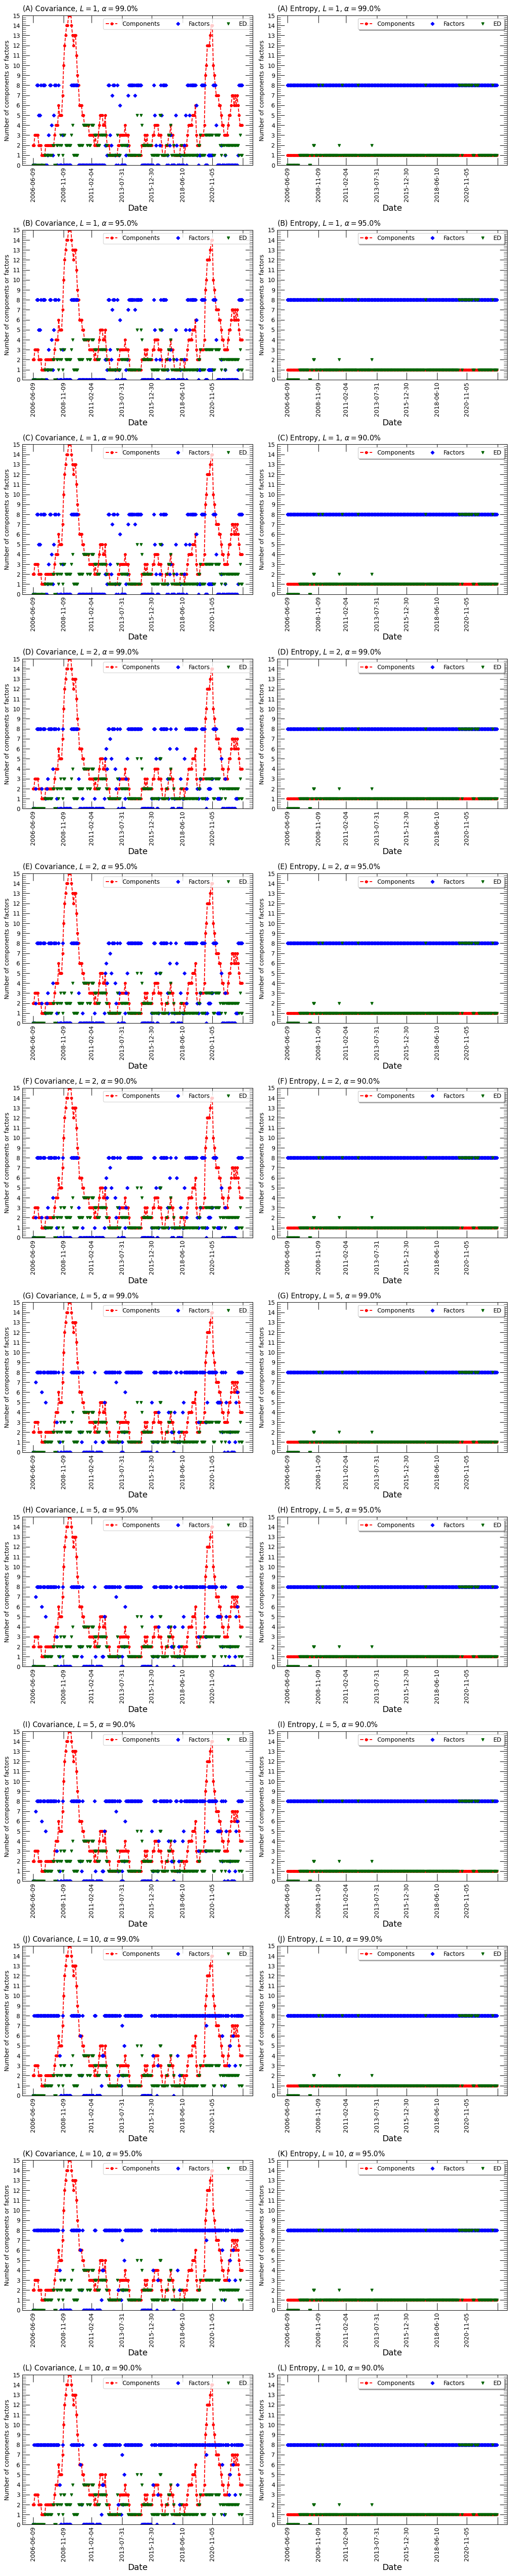

In [19]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as mtick # type: ignore

levels_ = df_final_3["level"].unique()
alphas_ = df_final_3["alpha"].unique()

fig,ax = plt.subplots(len(levels_) * len(alphas_), 2)
fig.set_size_inches(w = 12, h = 60)
ms = 4

for i in range(len(levels_)):
    for j in range(len(alphas_)):
        df_aux = df_final_3[((df_final_3["level"] == levels_[i]) & (df_final_3["alpha"] == alphas_[j]))]

        time_labels = pd.date_range(
            start = df_aux["final_date"].min(),
            end = df_aux["final_date"].max(),
            periods = 20
        ).strftime("%Y-%m-%d")

        # Components
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_components_cov"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_components_entropy"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        # Factors
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_factors_cov"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_factors_entropy"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        # Edge Distribution
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["edge_distribution_cov"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["edge_distribution_entropy"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        # Axis formatter
        ax[j + i * len(alphas_), 0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 0].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 0].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 0].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 0].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 0].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 0].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 0].legend(fancybox = True, shadow = False, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 0].set_title(
            r"({}) Covariance, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

        ax[j + i * len(alphas_), 1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 1].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 1].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 1].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 1].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 1].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 1].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 1].legend(fancybox = True, shadow = True, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 1].set_title(
            r"({}) Entropy, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_)+ 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

plt.tight_layout()
plt.show()

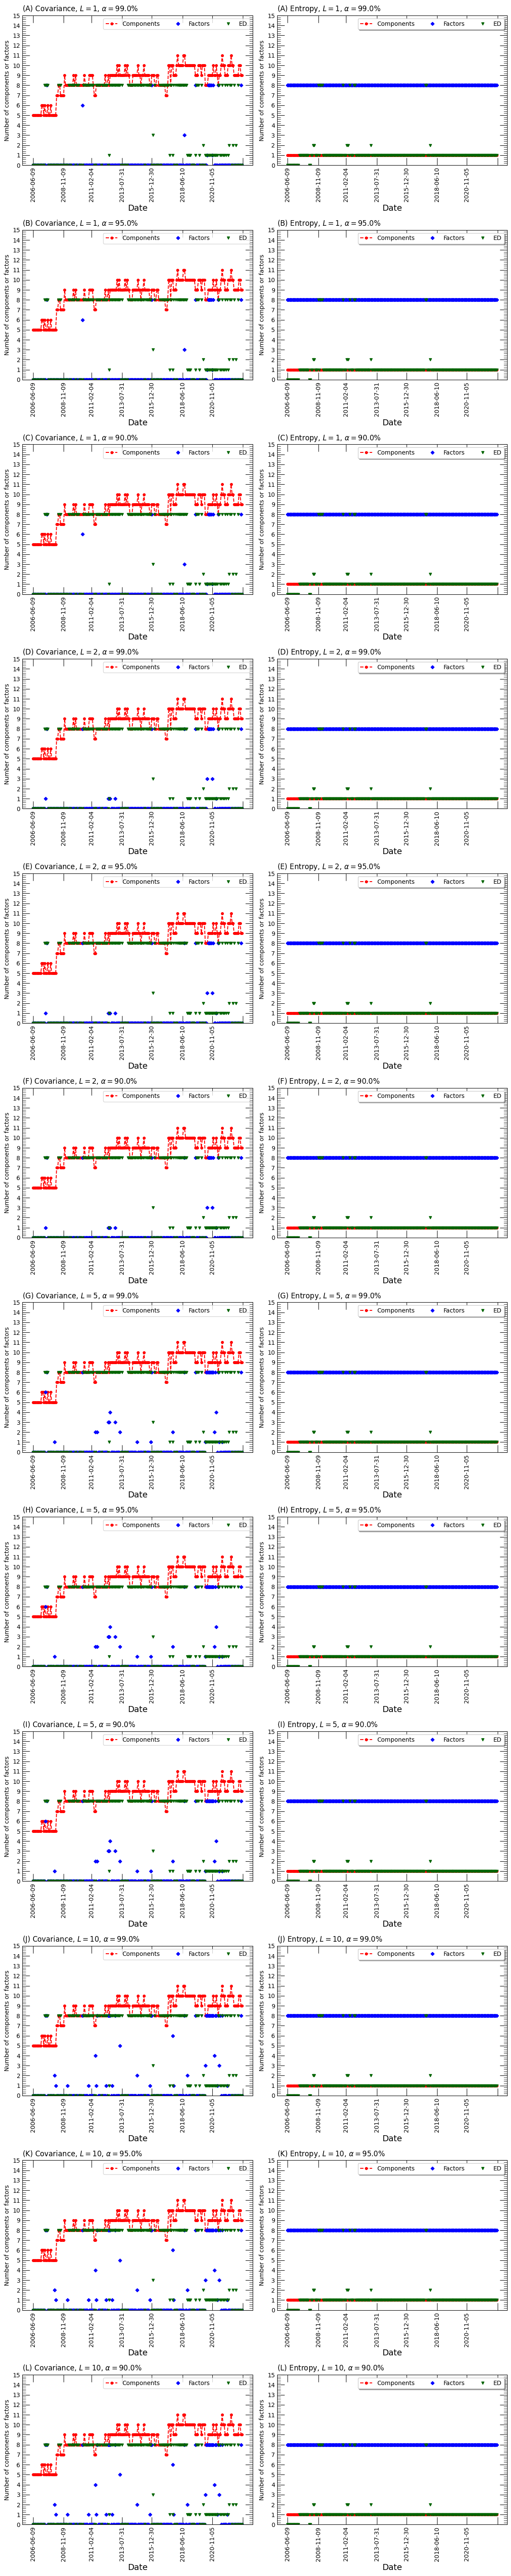

In [20]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as mtick # type: ignore

levels_ = df_final_4["level"].unique()
alphas_ = df_final_4["alpha"].unique()

fig,ax = plt.subplots(len(levels_) * len(alphas_), 2)
fig.set_size_inches(w = 12, h = 60)
ms = 4

for i in range(len(levels_)):
    for j in range(len(alphas_)):
        df_aux = df_final_4[((df_final_4["level"] == levels_[i]) & (df_final_4["alpha"] == alphas_[j]))]

        time_labels = pd.date_range(
            start = df_aux["final_date"].min(),
            end = df_aux["final_date"].max(),
            periods = 20
        ).strftime("%Y-%m-%d")

        # Components
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_components_cov"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_components_entropy"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        # Factors
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_factors_cov"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_factors_entropy"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        # Edge Distribution
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["edge_distribution_cov"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["edge_distribution_entropy"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        # Axis formatter
        ax[j + i * len(alphas_), 0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 0].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 0].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 0].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 0].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 0].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 0].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 0].legend(fancybox = True, shadow = False, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 0].set_title(
            r"({}) Covariance, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

        ax[j + i * len(alphas_), 1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 1].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 1].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 1].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 1].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 1].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 1].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 1].legend(fancybox = True, shadow = True, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 1].set_title(
            r"({}) Entropy, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

plt.tight_layout()
plt.show()